### The following notebook showcases the process behind the final project presented for the Eurekathon final in 2021, which was aimed at solving mobility challenges in the city of Matosinhos.

### Our strategy aimed at increasing micro-mobility in the city by 10% through the identification of areas with most potential demand. In order to reinforce our approach, we used unsupervised machine learning to classify them according to their specific characteristics. 

### With this, we were able to provide the city council with a tailor-made tool to expland micromobility infrastructure with a clear target. 

# Table of contents

* [1. Data cleaning and exploraton of short trips](#Short_trips)
* [2. Data cleaning and exploration of census data to enrich our research](#Census_data)
* [3. Obtaining our final table](#Final_table)
* [4. What would be the impact of increasing micromobility trips by 10%?](#Impact)
* [5. Modeling clusters to understand similarities between areas in the city ](#Modeling)

# 1. DATA CLEANING AND EXPLORATION OF SHORT TRIPS <a name="Short_trips"></a>

In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from osgeo import gdal
import shapely
import pandas as pd
import numpy as np
import warnings
from fiona.io import ZipMemoryFile
import requests
import seaborn as sns
from functools import reduce
from sklearn import cluster
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

# Run all you ask in one cell, not only the last required
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

#### Driving times dataset

In [2]:
%load_ext google.cloud.bigquery
from google.cloud import bigquery
bqclient=bigquery.Client()
query= '''SELECT* FROM eurekathon-hub.GEO.driving_times'''
driving_times= (
    bqclient.query(query)
    .result()
    .to_dataframe()
)
driving_times.head(5)

The google.cloud.bigquery extension is already loaded. To reload it, use:
  %reload_ext google.cloud.bigquery


row         s1     lat_s1    lon_s1         s2     lat_s2   lon_s2  \
0  48662  130806016  41.181835 -8.683804  130806006  41.187744 -8.67981   
1   7169  130806017  41.181389 -8.676742  130806006  41.187744 -8.67981   
2  60956  130806018  41.182140 -8.672269  130806006  41.187744 -8.67981   
3  20326  130806019  41.180870 -8.685215  130806006  41.187744 -8.67981   
4  28648  130806020  41.178543 -8.672639  130806006  41.187744 -8.67981   

      lin_dist  driving_time  driving_distance  
0   657.047053     57.717162       1179.454653  
1   706.675523     62.076689       1268.541925  
2   623.113048     54.736288       1118.540263  
3   764.363320     67.144174       1372.096367  
4  1023.110065     89.873334       1836.568509

In [3]:
# 1. distance into km
driving_times['driving_distance']  = driving_times['driving_distance'] .div(1000).round(2)
driving_times['driving_time']=driving_times['driving_time'].round(2)
driving_times['lin_dist']=driving_times['lin_dist'].round(2)
# driving_times.head()

# 2. statistical sections as string
driving_times['s1'] = driving_times['s1'].astype(str)
driving_times['s2'] = driving_times['s2'].astype(str)
driving_times.dtypes
# driving_times[['lin_dist','driving_time','driving_distance']].describe().round(2)

# 3. create new column for route
driving_times['route']=driving_times['s1']+','+driving_times['s2']
# driving_times.head()
# driving_times.shape
# driving_times['route'].nunique()
# '130805003,130805003' in driving_times['route']

# 4. find out the speed of each trip
driving_times['speed'] = (driving_times['driving_distance'] / (driving_times['driving_time']/3600)).astype('float64')
driving_times.describe()

# 5. save modified table
# driving_times.to_csv('driving_times.csv')


row                   int64
s1                   object
lat_s1              float64
lon_s1              float64
s2                   object
lat_s2              float64
lon_s2              float64
lin_dist            float64
driving_time        float64
driving_distance    float64
dtype: object

row        lat_s1        lon_s1        lat_s2        lon_s2  \
count  64262.000000  64262.000000  64262.000000  64262.000000  64262.000000   
mean   32130.500000     41.198747     -8.663538     41.198747     -8.663538   
std    18550.985836      0.019054      0.032175      0.019054      0.032175   
min        0.000000     41.174141     -8.724394     41.174141     -8.724394   
25%    16065.250000     41.185802     -8.689713     41.185802     -8.689713   
50%    32130.500000     41.193214     -8.666962     41.193214     -8.666962   
75%    48195.750000     41.206047     -8.637239     41.206047     -8.637239   
max    64261.000000     41.268730     -8.597434     41.268730     -8.597434   

           lin_dist  driving_time  driving_distance         speed  
count  64262.000000  64262.000000      64262.000000  64258.000000  
mean    2204.783963    193.675436          3.957727     73.531714  
std     2037.655634    178.994340          3.657751      2.553619  
min        0.000000      0.000000          0.000000      0.000000  
25%      666.800000     58.570000          1.200000     73.508772  
50%     1514.730000    133.060000          2.720000     73.565014  
75%     3214.820000    282.400000          5.770000     73.622351  
max    10517.840000    923.920000         18.880000    138.461538

#### Mobility flows dataset

In [4]:
%load_ext google.cloud.bigquery
from google.cloud import bigquery
bqclient=bigquery.Client()
query= '''SELECT* FROM eurekathon-hub.NOS.mobility_flows
WHERE Dia BETWEEN '2019-01-18T00:00:00.00' AND '2019-12-18T23:59:59.999' '''
trips= (
    bqclient.query(query)
    .result()
    .to_dataframe()
)
trips.head(5)

The google.cloud.bigquery extension is already loaded. To reload it, use:
  %reload_ext google.cloud.bigquery


Codigo_Seccao_A Codigo_Seccao_B  Longitude_Centroide_A  \
0     SC130810024     SC130801024              -8.638271   
1     SC130810024     SC130809021              -8.638271   
2     SC130810024     SC130809029              -8.638271   
3     SC130810024     SC130809033              -8.638271   
4     SC130810024     SC130809033              -8.638271   

   Latitude_Centroide_A  Longitude_Centroide_B  Latitude_Centroide_B  \
0             41.185772              -8.638076             41.188644   
1             41.185772              -8.630439             41.189449   
2             41.185772              -8.627929             41.185157   
3             41.185772              -8.629338             41.182761   
4             41.185772              -8.629338             41.182761   

    Segmento   Periodo_horario                       Dia    Formato_Transicao  \
0  Nacionais  1900195920002059 2019-03-24 00:00:00+00:00  2019-03-01 19:00:00   
1  Nacionais  1700175918001859 2019-03-24 00:00:00+00:00  2019-03-01 17:00:00   
2  Nacionais  2000205921002159 2019-03-24 00:00:00+00:00  2019-03-01 20:00:00   
3  Nacionais  1800185919001959 2019-03-24 00:00:00+00:00  2019-03-01 18:00:00   
4  Nacionais  1900195920002059 2019-03-24 00:00:00+00:00  2019-03-01 19:00:00   

   ... Nome_Concelho_A Codigo_Concelho_B Nome_Concelho_B Nacionais_BA  \
0  ...      MATOSINHOS            CO1308      MATOSINHOS           21   
1  ...      MATOSINHOS            CO1308      MATOSINHOS            7   
2  ...      MATOSINHOS            CO1308      MATOSINHOS            7   
3  ...      MATOSINHOS            CO1308      MATOSINHOS            7   
4  ...      MATOSINHOS            CO1308      MATOSINHOS            7   

   Nacionais_AB  Estrangeiros_BA  Estrangeiros_AB  Nacionais_AA_ou_BB  \
0            21                0                0                   0   
1             7                0                0                   0   
2             7                0                0                   0   
3             7                0                0                   0   
4             7                0                0                   0   

   Estrangeiros_AA_ou_BB      Pais  
0                      0  Portugal  
1                      0  Portugal  
2                      0  Portugal  
3                      0  Portugal  
4                      0  Portugal  

[5 rows x 21 columns]

In [5]:
# create new columns and adapt table for further manipulation
trips['Codigo_Seccao_A'] = trips['Codigo_Seccao_A'].str[2:]
trips['Codigo_Seccao_B'] = trips['Codigo_Seccao_B'].str[2:]
trips['route']= trips['Codigo_Seccao_A']+','+trips['Codigo_Seccao_B']
trips['people']=trips['Nacionais_BA']+trips['Nacionais_AB']+trips['Estrangeiros_BA']+trips['Estrangeiros_AB']+trips['Nacionais_AA_ou_BB']+trips['Estrangeiros_AA_ou_BB']

trips.shape
trips['route'].nunique()
trips['people'].sum()
trips.columns

(12583451, 23)

16705

197371646

Index(['Codigo_Seccao_A', 'Codigo_Seccao_B', 'Longitude_Centroide_A',
       'Latitude_Centroide_A', 'Longitude_Centroide_B', 'Latitude_Centroide_B',
       'Segmento', 'Periodo_horario', 'Dia', 'Formato_Transicao',
       'Codigo_Concelho_A', 'Nome_Concelho_A', 'Codigo_Concelho_B',
       'Nome_Concelho_B', 'Nacionais_BA', 'Nacionais_AB', 'Estrangeiros_BA',
       'Estrangeiros_AB', 'Nacionais_AA_ou_BB', 'Estrangeiros_AA_ou_BB',
       'Pais', 'route', 'people'],
      dtype='object')

#### Merge mobility flows and trip distance datasets

In [6]:
# 1.drop some columns
trips = trips.drop(['Longitude_Centroide_A','Latitude_Centroide_A', 'Longitude_Centroide_B', 'Latitude_Centroide_B','Segmento','Codigo_Concelho_A', 
                    'Nome_Concelho_A', 'Codigo_Concelho_B','Nome_Concelho_B', 'Nacionais_BA', 'Nacionais_AB', 'Estrangeiros_BA','Estrangeiros_AB', 
                    'Nacionais_AA_ou_BB', 'Estrangeiros_AA_ou_BB','Pais'],axis=1)
driving_times = driving_times.drop(['lat_s1','lon_s1','lat_s2','lon_s2','lin_dist','driving_time','speed'],axis=1)

trips.head(2)
driving_times.head(2)

# 2.merge datasets
merged = pd.merge(trips,driving_times,left_on='route',right_on='route')
merged.head()
merged.columns
merged.shape

Codigo_Seccao_A Codigo_Seccao_B   Periodo_horario                       Dia  \
0       130810024       130801024  1900195920002059 2019-03-24 00:00:00+00:00   
1       130810024       130809021  1700175918001859 2019-03-24 00:00:00+00:00   

     Formato_Transicao                route  people  
0  2019-03-01 19:00:00  130810024,130801024      42  
1  2019-03-01 17:00:00  130810024,130809021      14

row         s1         s2  driving_distance                route
0  48662  130806016  130806006              1.18  130806016,130806006
1   7169  130806017  130806006              1.27  130806017,130806006

Codigo_Seccao_A Codigo_Seccao_B   Periodo_horario                       Dia  \
0       130810024       130801024  1900195920002059 2019-03-24 00:00:00+00:00   
1       130810024       130801024   900095910001059 2019-03-24 00:00:00+00:00   
2       130810024       130801024  2100215922002259 2019-03-24 00:00:00+00:00   
3       130810024       130801024   600065907000759 2019-03-24 00:00:00+00:00   
4       130810024       130801024   500055906000659 2019-03-24 00:00:00+00:00   

     Formato_Transicao                route  people   row         s1  \
0  2019-03-01 19:00:00  130810024,130801024      42  8094  130810024   
1  2019-03-01 09:00:00  130810024,130801024      18  8094  130810024   
2  2019-03-01 21:00:00  130810024,130801024      20  8094  130810024   
3  2019-03-01 06:00:00  130810024,130801024      14  8094  130810024   
4  2019-03-01 05:00:00  130810024,130801024      14  8094  130810024   

          s2  driving_distance  
0  130801024              0.57  
1  130801024              0.57  
2  130801024              0.57  
3  130801024              0.57  
4  130801024              0.57

Index(['Codigo_Seccao_A', 'Codigo_Seccao_B', 'Periodo_horario', 'Dia',
       'Formato_Transicao', 'route', 'people', 'row', 's1', 's2',
       'driving_distance'],
      dtype='object')

(11704831, 11)

### Calculate the distance that most micromobility trips cover. We will call these 'short trips' and we will check what is the share of short trips in the dataset

The google.cloud.bigquery extension is already loaded. To reload it, use:
  %reload_ext google.cloud.bigquery


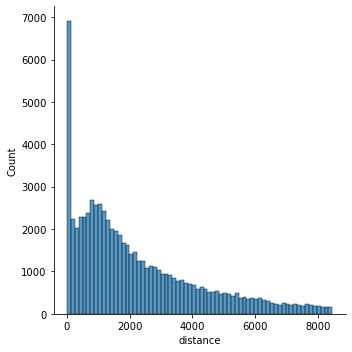

In [7]:
# load dataset micro mobility
%load_ext google.cloud.bigquery
from google.cloud import bigquery
bqclient=bigquery.Client()
query= '''SELECT * FROM eurekathon-hub.CEIIA.shared_micromobility
LIMIT 100000'''
df_micro_mob= (
    bqclient.query(query)
    .result()
    .to_dataframe()
)

df_micro_mob['distance'] = pd.to_numeric(df_micro_mob['distance'],errors = 'coerce')
#taking out the zeros from distance
data = df_micro_mob.drop(df_micro_mob[df_micro_mob['distance'] < 10].index)

#calculate IQR
iqr = np.percentile(data['distance'],75) - np.percentile(data['distance'],25)
upper_limit = np.percentile(data['distance'],75) + 1.5*iqr
lower_limit = np.percentile(data['distance'],25) - 1.5*iqr
data = data[(data['distance']>lower_limit) & (data['distance']<upper_limit)]
sns.displot(data['distance'])
plt.show()

In [8]:
df_distance_time = data.drop(['vehicle_id','session_id','type','start_time','end_time','saved_emissions','route'], axis=1)
sort_data = df_distance_time.sort_values(by=['distance'], ascending=True)
# calculate the interquartile range and compare to the mean:
Q1 = np.percentile(sort_data, 25, interpolation = 'midpoint') 
Q2 = np.percentile(sort_data, 50, interpolation = 'midpoint') 
Q3 = np.percentile(sort_data, 75, interpolation = 'midpoint') 

print('Q1 25 percentile of the given data is, ', Q1)
print('Q2 50 percentile of the given data is, ', Q2)
print('Q3 75 percentile of the given data is, ', Q3)

IQR = Q3 - Q1 
print('Interquartile range is', IQR)

Q1 25 percentile of the given data is,  709.0
Q2 50 percentile of the given data is,  1607.0
Q3 75 percentile of the given data is,  3250.0
Interquartile range is 2541.0


### 75% of all micromobility trips are below 3.25 kms. We will filter our trips dataset and keep only those, which we consider to be short trips and suitable for micromobility purposes

In [9]:
short_trips= merged[merged['driving_distance'] <3.25]
short_trips.head()
short_trips.shape

# keep datasets for later
# short_trips.to_csv('short_trips.csv')
# long_trips = merged
# long_trips.to_csv('long_trips.csv')

Codigo_Seccao_A Codigo_Seccao_B   Periodo_horario                       Dia  \
0       130810024       130801024  1900195920002059 2019-03-24 00:00:00+00:00   
1       130810024       130801024   900095910001059 2019-03-24 00:00:00+00:00   
2       130810024       130801024  2100215922002259 2019-03-24 00:00:00+00:00   
3       130810024       130801024   600065907000759 2019-03-24 00:00:00+00:00   
4       130810024       130801024   500055906000659 2019-03-24 00:00:00+00:00   

     Formato_Transicao                route  people   row         s1  \
0  2019-03-01 19:00:00  130810024,130801024      42  8094  130810024   
1  2019-03-01 09:00:00  130810024,130801024      18  8094  130810024   
2  2019-03-01 21:00:00  130810024,130801024      20  8094  130810024   
3  2019-03-01 06:00:00  130810024,130801024      14  8094  130810024   
4  2019-03-01 05:00:00  130810024,130801024      14  8094  130810024   

          s2  driving_distance  
0  130801024              0.57  
1  130801024              0.57  
2  130801024              0.57  
3  130801024              0.57  
4  130801024              0.57

(10568145, 11)

### 90% of all our trips dataset correspond to short trips. That's quite a statement

In [10]:
short_trips_percentage = round(len(short_trips)/len(merged)*100,2)
print (str(short_trips_percentage)+'% of all trips are below 3.25 kms')

90.29% of all trips are below 3.25 kms


### Identify sections number of people starting a trip per statistical section

In [11]:
start_rank = short_trips.groupby(['Codigo_Seccao_A']).agg({'Codigo_Seccao_A':'count','people':'sum'})
start_rank.rename(columns={"Codigo_Seccao_A": "count"}, inplace=True)
start_rank.head()

start_ranking = start_rank.sort_values(by='count', ascending=False)
start_ranking = start_ranking.reset_index()

start_ranking['%people'] = (start_ranking['people']/short_trips['people'].sum())*100
start_ranking.head()

start_ranking['%people'].sum()
start_ranking.shape

start_ranking.to_csv('start_ranking.csv')

# top_routes['share'].iloc[0:450].sum()

count  people
Codigo_Seccao_A               
130801001        57746  869555
130801002        34845  489679
130801003        66045  961915
130801004        59258  861840
130801005        41431  568012

Codigo_Seccao_A   count   people   %people
0       130806002  195155  3606843  2.102942
1       130801009  157956  2717293  1.584297
2       130806001  136966  2207231  1.286909
3       130801014  136846  2481622  1.446891
4       130804018  134421  2600212  1.516034

100.0

(249, 4)

### Identify number of people ending a trip per statistical section

In [12]:
end_rank = short_trips.groupby(['Codigo_Seccao_B']).agg({'Codigo_Seccao_B':'count','people':'sum'})
end_rank.rename(columns={"Codigo_Seccao_B": "count"}, inplace=True)
end_rank.head()

end_ranking = end_rank.sort_values(by='count', ascending=False)
end_ranking = end_ranking.reset_index()

end_ranking['%people'] = (end_ranking['people']/short_trips['people'].sum())*100
end_ranking.head()

end_ranking['%people'].sum()
end_ranking.shape

end_ranking.to_csv('end_ranking.csv')

count  people
Codigo_Seccao_B               
130801001        57882  870691
130801002        34765  489131
130801003        65752  959879
130801004        59699  864942
130801005        41153  566070

Codigo_Seccao_B   count   people   %people
0       130806002  195704  3611001  2.105366
1       130801009  158171  2719033  1.585311
2       130806001  138049  2214936  1.291401
3       130801014  137457  2485992  1.449439
4       130804018  135211  2606258  1.519559

100.0

(249, 4)

### Rank short trip routes according to number of people

In [13]:
rank = short_trips.groupby(['route']).agg({'route':'count','people':'sum'})
rank.rename(columns={"route": "count"}, inplace=True)

ranking = rank.sort_values(by='count', ascending=False)
top_routes = ranking.reset_index()

top_routes['share'] = (top_routes['people']/short_trips['people'].sum())*100
top_routes.head()

# first 400 combinations acount for 20% of the total trips
top_routes['share'].sum()
top_routes['share'].iloc[0:400].sum()

route  count  people     share
0  130808008,130805003   6373  253221  0.147639
1  130805003,130808008   6369  253198  0.147625
2  130805005,130806002   5634  226516  0.132068
3  130806002,130805005   5628  226410  0.132007
4  130805005,130805003   4721  166391  0.097013

100.0

20.281954493883656

### Top routes carrying 20% of the people (we are not checking trips among the same sections because we do not have data about them in terms of distance)

In [14]:
target = top_routes.iloc[0:400]
# target.head(2)
# driving_times.head(2)

busy_routes = pd.merge(target,driving_times,left_on='route',right_on='route')
busy_routes.head(2)
busy_routes.shape

route  count  people     share    row         s1         s2  \
0  130808008,130805003   6373  253221  0.147639  50891  130808008  130805003   
1  130805003,130808008   6369  253198  0.147625  42182  130805003  130808008   

   driving_distance  
0              0.03  
1              0.03

(400, 8)

### Plotting some insights

Text(0.5, 1.0, 'Statistical sections of Matoshinos')

<AxesSubplot:>

Text(0.5, 1.0, 'Total people starting a trip by statistical section in a four-month period')

<AxesSubplot:>

Text(0.5, 1.0, 'Total people ending a trip per statistical section in a four-month period')

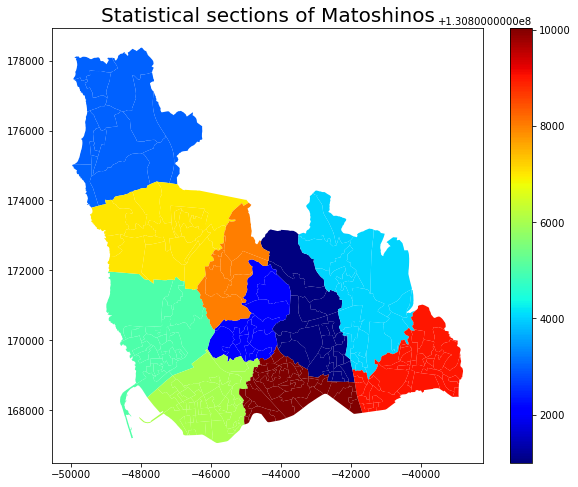

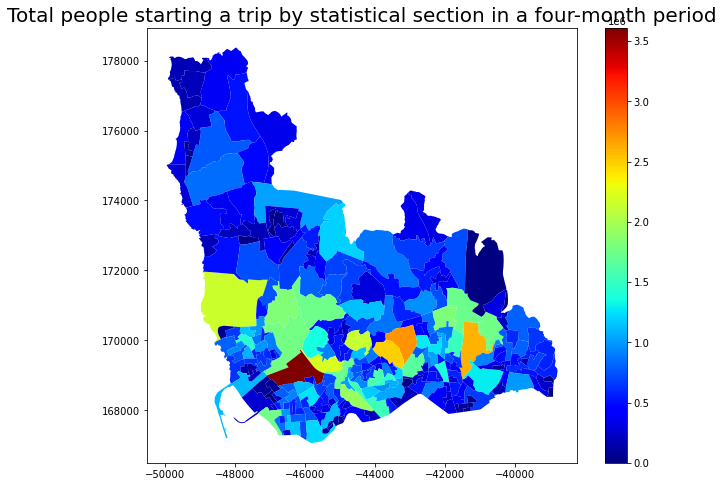

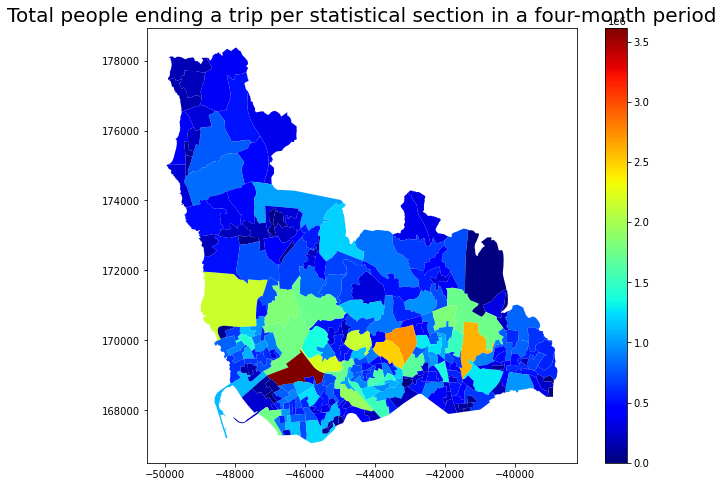

In [15]:
# Statistical sections
sec_est = gpd.read_file('sec_est')
sec_est = sec_est.plot(cmap = 'jet', column='SEC_EST', figsize = (10,8),legend=True)
plt.title("Statistical sections of Matoshinos",fontsize =20)


# Total people starting a trip by statistical section in a four-month period
start_sections = gpd.read_file('start_sections')
# start_sections.head(2)
start_sections.plot(cmap='jet',column='people',figsize = (10,8), legend=True)
plt.title("Total people starting a trip by statistical section in a four-month period",fontsize =20)


# Total people ending a trip per statistical section in a four-month period
end_sections = gpd.read_file('end_sections')
# end_sections.head(2)
end_sections.plot(cmap='jet',column='people',figsize = (10,8), legend=True)
plt.title("Total people ending a trip per statistical section in a four-month period",fontsize =20)

# 2. DATA CLEANING AND EXPLORATION OF CENSUS DATA TO ENRICH OUR RESEARCH <a name="Census_data"></a>

In [16]:
#cleaning the sc data ' needs to be removed
def remove_quote_sign(x):
  if type(x)==str:
    return x.replace("'"," ")
    
  else:
    return float(x)
def conv_float(x):
  if type(x) == str:
    return float(x)
  else:
    return x

In [17]:
# open dataset
path_census_2011_csv = 'CMM/Censos_2011/BGRI2011_1308.csv'
df_census_2011_csv = pd.read_csv(path_census_2011_csv,encoding ='latin-1',delimiter=';')
# df_census_2011_csv.head(2)

df_cs2011_fv = pd.read_csv('CMM/Censos_2011/C2011_FSINTESE_VARIAVEIS.csv',encoding ='latin-1',delimiter=';')

# df_census_2011_csv.columns
# df_census_2011_csv.shape
# df_census_2011_csv.describe()

#dropping columns that we don't need
df_census_n = df_census_2011_csv.drop(['N_EDIFICIOS_CLASSICOS', 'N_EDIFICIOS_CLASSICOS_1OU2', 'N_EDIFICIOS_CLASSICOS_ISOLADOS ',
 'N_EDIFICIOS_CLASSICOS_GEMIN', 'N_EDIFICIOS_CLASSICOS_EMBANDA', 'N_EDIFICIOS_CLASSICOS_3OUMAIS', 'N_EDIFICIOS_CLASSICOS_OUTROS',
 'N_EDIFICIOS_EXCLUSIV_RESID', 'N_EDIFICIOS_PRINCIPAL_RESID', 'N_EDIFICIOS_PRINCIP_NAO_RESID', 'N_EDIFICIOS_1OU2_PISOS',
 'N_EDIFICIOS_3OU4_PISOS', '.N_EDIFICIOS_5OU_MAIS_PISOS', 'N_EDIFICIOS_CONSTR_ANTES_1919', 'N_EDIFICIOS_CONSTR_1919A1945',
 'N_EDIFICIOS_CONSTR_1946A1960', 'N_EDIFICIOS_CONSTR_1961A1970', 'N_EDIFICIOS_CONSTR_1971A1980', 'N_EDIFICIOS_CONSTR_1981A1990',
 'N_EDIFICIOS_CONSTR_1991A1995', 'N_EDIFICIOS_CONSTR_1996A2000', 'N_EDIFICIOS_CONSTR_2001A2005', 'N_EDIFICIOS_CONSTR_2006A2011',
 'N_EDIFICIOS_ESTRUT_BETAO', 'N_EDIFICIOS_ESTRUT_COM_PLACA', 'N_EDIFICIOS_ESTRUT_SEM_PLACA', 'N_EDIFICIOS_ESTRUT_ADOBE_PEDRA',
 'N_EDIFICIOS_ESTRUT_OUTRA', 'N_ALOJAMENTOS', 'N_ALOJAMENTOS_FAMILIARES', 'N_ALOJAMENTOS_FAM_CLASSICOS', 'N_ALOJAMENTOS_FAM_N_CLASSICOS', 'N_ALOJAMENTOS_COLECTIVOS', 'N_CLASSICOS_RES_HABITUAL', 'N_ALOJAMENTOS_RES_HABITUAL',
 'N_ALOJAMENTOS_VAGOS', 'N_RES_HABITUAL_COM_AGUA', 'N_RES_HABITUAL_COM_RETRETE', 'N_RES_HABITUAL_COM_ESGOTOS', 'N_RES_HABITUAL_COM_BANHO', 'N_RES_HABITUAL_AREA_50', 'N_RES_HABITUAL_AREA_50_100', 'N_RES_HABITUAL_AREA_100_200',
 'N_RES_HABITUAL_AREA_200', 'N_RES_HABITUAL_1_2_DIV', 'N_RES_HABITUAL_3_4_DIV', 'N_RES_HABITUAL_ESTAC_1', 'N_RES_HABITUAL_ESTAC_2', 'N_RES_HABITUAL_ESTAC_3',
 'N_RES_HABITUAL_PROP_OCUP', 'N_RES_HABITUAL_ARREND', 'N_FAMILIAS_CLASSICAS', 'N_FAMILIAS_INSTITUCIONAIS', 'N_FAMILIAS_CLASSICAS_1OU2_PESS', 'N_FAMILIAS_CLASSICAS_3OU4_PESS', 'N_FAMILIAS_CLASSICAS_NPES65', 'N_FAMILIAS_CLASSICAS_NPES14',
 'N_FAMILIAS_CLASSIC_SEM_DESEMP', 'N_FAMILIAS_CLASSIC_1DESEMPREG', 'N_FAMILIAS_CLASS_2MAIS_DESEMP', 'N_NUCLEOS_FAMILIARES',
 'N_NUCLEOS_1FILH_NAO_CASADO', 'N_NUCLEOS_2FILH_NAO_CASADO', 'N_NUCLEOS_FILH_INF_6ANOS', 'N_NUCLEOS_FILH_INF_15ANOS', 'N_NUCLEOS_FILH_MAIS_15ANOS', 'N_INDIVIDUOS_PRESENT', 'N_INDIVIDUOS_PRESENT_H', 'N_INDIVIDUOS_PRESENT_M', 'N_INDIV_RESIDENT_N_LER_ESCRV', 'N_IND_RESIDENT_FENSINO_1BAS',
 'N_IND_RESIDENT_FENSINO_2BAS', 'N_IND_RESIDENT_FENSINO_3BAS', 'N_IND_RESIDENT_FENSINO_SEC', 'N_IND_RESIDENT_FENSINO_POSSEC',
 'N_IND_RESIDENT_FENSINO_SUP', 'N_IND_RESIDENT_ENSINCOMP_1BAS', 'N_IND_RESIDENT_ENSINCOMP_2BAS', 'N_IND_RESIDENT_ENSINCOMP_3BAS', 'N_IND_RESIDENT_ENSINCOMP_SEC',
 'N_IND_RESIDENT_ENSINCOMP_POSEC', 'N_IND_RESIDENT_ENSINCOMP_SUP'],axis=1)
# df_census_n.head()

df_census_n = df_census_n.drop(['Unnamed: 127'],axis=1)


df_census_people = df_census_n.drop(['N_IND_RESID_DESEMP_PROC_1EMPRG', 'N_IND_RESID_DESEMP_PROC_EMPRG', 'N_IND_RESID_EMPREGADOS', 'N_IND_RESID_PENS_REFORM', 'N_IND_RESID_SEM_ACT_ECON', 'N_IND_RESID_EMPREG_SECT_PRIM', 'N_IND_RESID_EMPREG_SECT_SEQ', 'N_IND_RESID_EMPREG_SECT_TERC', 'N_IND_RESID_ESTUD_MUN_RESID', 'N_IND_RESID_TRAB_MUN_RESID'],axis=1)

df_census_income = df_census_n.drop(['N_INDIVIDUOS_RESIDENT', 'N_INDIVIDUOS_RESIDENT_H','N_INDIVIDUOS_RESIDENT_M', 'N_INDIVIDUOS_RESIDENT_0A4', 'N_INDIVIDUOS_RESIDENT_5A9', 'N_INDIVIDUOS_RESIDENT_10A13', 'N_INDIVIDUOS_RESIDENT_14A19', 'N_INDIVIDUOS_RESIDENT_15A19', 'N_INDIVIDUOS_RESIDENT_20A24', 'N_INDIVIDUOS_RESIDENT_20A64', 'N_INDIVIDUOS_RESIDENT_25A64', 'N_INDIVIDUOS_RESIDENT_65', 'N_INDIVIDUOS_RESIDENT_H_0A4', 'N_INDIVIDUOS_RESIDENT_H_5A9', 'N_INDIVIDUOS_RESIDENT_H_10A13', 'N_INDIVIDUOS_RESIDENT_H_14A19', 'N_INDIVIDUOS_RESIDENT_H_15A19', 'N_INDIVIDUOS_RESIDENT_H_20A24', 'N_INDIVIDUOS_RESIDENT_H_20A64', 'N_INDIVIDUOS_RESIDENT_H_25A64', 'N_INDIVIDUOS_RESIDENT_H_65', 'N_INDIVIDUOS_RESIDENT_M_0A4', 'N_INDIVIDUOS_RESIDENT_M_5A9', 'N_INDIVIDUOS_RESIDENT_M_10A13', 'N_INDIVIDUOS_RESIDENT_M_14A19', 'N_INDIVIDUOS_RESIDENT_M_15A19', 'N_INDIVIDUOS_RESIDENT_M_20A24', 'N_INDIVIDUOS_RESIDENT_M_20A64',
 'N_INDIVIDUOS_RESIDENT_M_25A64', 'N_INDIVIDUOS_RESIDENT_M_65'],axis=1)

df_census_n1 = df_census_n.drop([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14],axis=0).reset_index()
# df_census_n1.sample(15)

#dropping subseccao rows as all of our other datasets have only seccao geo-code
df_census_sc = df_census_n1.drop(df_census_n1[df_census_n1['NIVEL'] > 7].index)
#data = df_micro_mob.drop(df_micro_mob[df_micro_mob['distance'] < 10].index)
# df_census_sc.head()

col_names_sc = df_census_sc.columns.tolist()

df_census_sc_final = df_census_sc.drop(['index','GEO_COD_DSG','NIVEL','NIVEL_DSG', 'N_INDIVIDUOS_RESIDENT_H', 'N_INDIVIDUOS_RESIDENT_M', 'N_INDIVIDUOS_RESIDENT_H_0A4', 'N_INDIVIDUOS_RESIDENT_H_5A9', 'N_INDIVIDUOS_RESIDENT_H_10A13', 'N_INDIVIDUOS_RESIDENT_H_14A19', 'N_INDIVIDUOS_RESIDENT_H_15A19', 'N_INDIVIDUOS_RESIDENT_H_20A24', 'N_INDIVIDUOS_RESIDENT_H_20A64', 'N_INDIVIDUOS_RESIDENT_H_25A64', 'N_INDIVIDUOS_RESIDENT_H_65', 'N_INDIVIDUOS_RESIDENT_M_0A4', 'N_INDIVIDUOS_RESIDENT_M_5A9', 'N_INDIVIDUOS_RESIDENT_M_10A13', 'N_INDIVIDUOS_RESIDENT_M_14A19', 'N_INDIVIDUOS_RESIDENT_M_15A19', 'N_INDIVIDUOS_RESIDENT_M_20A24', 'N_INDIVIDUOS_RESIDENT_M_20A64', 'N_INDIVIDUOS_RESIDENT_M_25A64', 'N_INDIVIDUOS_RESIDENT_M_65'],axis=1)

df_census_sc_final['GEO_COD'] = list(map(remove_quote_sign,df_census_sc_final['GEO_COD']))
# df_census_sc_final['GEO_COD'].head()

df_census_sc_final.head(2)
df_census_sc_final.shape
df_census_sc_final.to_csv('census_2011.csv',index = False)

ANO     GEO_COD  N_INDIVIDUOS_RESIDENT  N_INDIVIDUOS_RESIDENT_0A4  \
0  2011   130801001                    606                         21   
1  2011   130801002                    547                         23   

   N_INDIVIDUOS_RESIDENT_5A9  N_INDIVIDUOS_RESIDENT_10A13  \
0                         18                           22   
1                         19                           23   

   N_INDIVIDUOS_RESIDENT_14A19  N_INDIVIDUOS_RESIDENT_15A19  \
0                           40                           34   
1                           35                           33   

   N_INDIVIDUOS_RESIDENT_20A24  N_INDIVIDUOS_RESIDENT_20A64  ...  \
0                           33                          380  ...   
1                           41                          340  ...   

   N_IND_RESID_DESEMP_PROC_1EMPRG  N_IND_RESID_DESEMP_PROC_EMPRG  \
0                               7                             47   
1                               4                             54   

   N_IND_RESID_EMPREGADOS  N_IND_RESID_PENS_REFORM  N_IND_RESID_SEM_ACT_ECON  \
0                     244                      148                       241   
1                     202                      129                       220   

   N_IND_RESID_EMPREG_SECT_PRIM  N_IND_RESID_EMPREG_SECT_SEQ  \
0                             7                           73   
1                            14                           72   

   N_IND_RESID_EMPREG_SECT_TERC  N_IND_RESID_ESTUD_MUN_RESID  \
0                           164                           70   
1                           116                           83   

   N_IND_RESID_TRAB_MUN_RESID  
0                         160  
1                         131  

[2 rows x 22 columns]

(254, 22)

<Figure size 1440x720 with 0 Axes>

<AxesSubplot:>

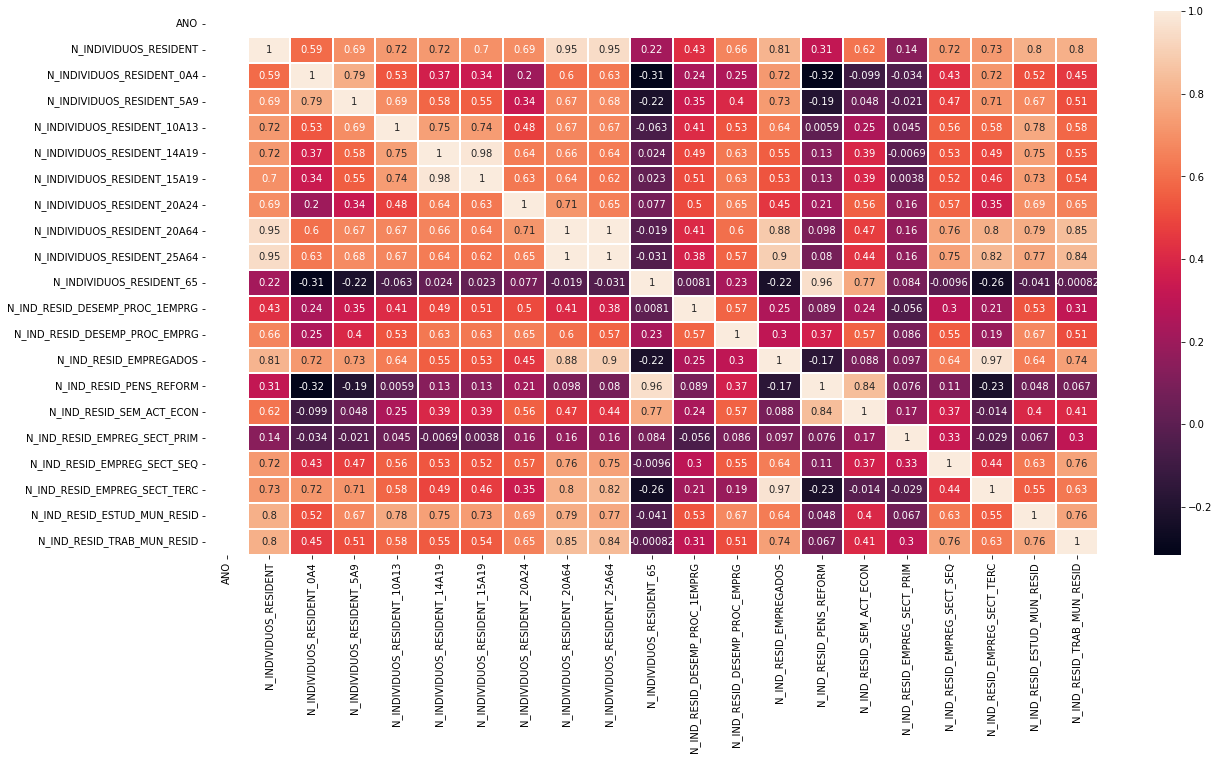

sum                            \
     N_INDIVIDUOS_RESIDENT N_INDIVIDUOS_RESIDENT_0A4   
ANO                                                    
2011                175478                      8047   

                                                              \
     N_INDIVIDUOS_RESIDENT_10A13 N_INDIVIDUOS_RESIDENT_14A19   
ANO                                                            
2011                        7132                       10801   

                                                              \
     N_INDIVIDUOS_RESIDENT_20A24 N_INDIVIDUOS_RESIDENT_25A64   
ANO                                                            
2011                        9756                      103230   

                                                         
     N_INDIVIDUOS_RESIDENT_5A9 N_INDIVIDUOS_RESIDENT_65  
ANO                                                      
2011                      8227                    28285

In [18]:
correlations_matrix = df_census_sc_final.corr()

#creating heatmap
plt.figure(figsize = (20,10))
sns.heatmap(correlations_matrix,annot =True, linewidths =.10, data=df_census_sc_final)
plt.show()

pivot_table_age = df_census_sc_final.pivot_table(index =['ANO'], values =['N_INDIVIDUOS_RESIDENT', 'N_INDIVIDUOS_RESIDENT_0A4','N_INDIVIDUOS_RESIDENT_5A9', 'N_INDIVIDUOS_RESIDENT_10A13', 'N_INDIVIDUOS_RESIDENT_14A19','N_INDIVIDUOS_RESIDENT_20A24','N_INDIVIDUOS_RESIDENT_25A64', 'N_INDIVIDUOS_RESIDENT_65'],aggfunc=['sum'], dropna=False)
pivot_table_age

# 3. OBTAINING OUR FINAL TABLE <a name="Final_table"></a>

In [19]:
# SECTIONS
sections = gpd.read_file('sec_est')
# sections.shape
# sections.head()

### START SECTIONS
start_sections = gpd.read_file('start_sections')
start_sections = start_sections.drop(['Shape_Leng','Field1','Codigo_Sec','F_people','Shape_Le_1','Shape_Area','geometry'],axis=1)
start_sections.rename(columns={"count": "start_trips","people": "start_people"}, inplace=True)
# start_sections.shape
# start_sections.head()

### END SECTIONS
end_sections = gpd.read_file('end_sections')
end_sections = end_sections.drop(['Shape_Leng','Field1','Codigo_Sec','F_people','Shape_Le_1','Shape_Area'],axis=1)
end_sections.rename(columns={"count": "end_trips","people": "end_people"}, inplace=True)
# end_sections.shape
# end_sections.head()

### SCHOOLS
schools = gpd.read_file('schools.csv')
schools.rename(columns={"School": "number_schools"}, inplace=True)
schools = schools.drop(['geometry'],axis=1)
# schools.shape
# schools.head()

### BUSINESSES
businesses = gpd.read_file('econ_activities.csv')
businesses.rename(columns={"Economic_center": "number_businesses"}, inplace=True)
businesses = businesses.drop(['geometry'],axis=1)
businesses = businesses.iloc[1: , :]
# businesses.shape
# businesses.head()

### METRO
metro = pd.read_excel('metro.xlsx')
metro = metro.drop(['Shape_Area','Shape_Length'],axis=1)
# metro.head()
# metro.shape

### BUS
bus = pd.read_excel('bus.xlsx')
bus = bus.drop(['Shape_Area','Shape_Length'],axis=1)
# bus['bus_stop'] = bus['bus_stop'].astype(int)
# bus.head()
# bus.shape

### CENSUS
census = gpd.read_file('census_2011.csv')
# census.head()

# convert object columns to integer
cols = ['N_INDIVIDUOS_RESIDENT_5A9','N_INDIVIDUOS_RESIDENT_10A13','N_INDIVIDUOS_RESIDENT_14A19','N_INDIVIDUOS_RESIDENT_20A24','N_INDIVIDUOS_RESIDENT', 'N_IND_RESID_EMPREGADOS']
census[cols] = census[cols].apply(pd.to_numeric, errors='coerce', axis=1)

# rename some columns
census.rename(columns={"N_INDIVIDUOS_RESIDENT": "total_pop",'N_IND_RESID_EMPREGADOS':'employed_pop','GEO_COD':'SEC_EST'}, inplace=True)

census['young_population'] =  census[['N_INDIVIDUOS_RESIDENT_5A9','N_INDIVIDUOS_RESIDENT_10A13','N_INDIVIDUOS_RESIDENT_14A19','N_INDIVIDUOS_RESIDENT_20A24']].sum(axis=1)

census = census.drop(['ANO','N_INDIVIDUOS_RESIDENT_0A4','N_INDIVIDUOS_RESIDENT_15A19','N_INDIVIDUOS_RESIDENT_20A64','N_INDIVIDUOS_RESIDENT_25A64', 'N_INDIVIDUOS_RESIDENT_65','N_IND_RESID_DESEMP_PROC_1EMPRG', 
                      'N_IND_RESID_DESEMP_PROC_EMPRG','N_IND_RESID_PENS_REFORM','N_IND_RESID_SEM_ACT_ECON', 'N_IND_RESID_EMPREG_SECT_PRIM','N_IND_RESID_EMPREG_SECT_SEQ', 'N_IND_RESID_EMPREG_SECT_TERC', 'N_IND_RESID_ESTUD_MUN_RESID', 
                      'N_IND_RESID_TRAB_MUN_RESID','N_INDIVIDUOS_RESIDENT_5A9','N_INDIVIDUOS_RESIDENT_10A13','N_INDIVIDUOS_RESIDENT_14A19','N_INDIVIDUOS_RESIDENT_20A24','geometry'],axis=1)

census.head()

/opt/conda/lib/python3.7/site-packages/openpyxl/worksheet/header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


SEC_EST  total_pop  employed_pop  young_population
0   130801001        606           244               113
1   130801002        547           202               118
2   130801003       1171           541               196
3   130801004        676           277               118
4   130801005        813           413               191

# combine final table

In [20]:
# 1. start + end
start_end = pd.merge(start_sections,end_sections,left_index=True, right_index=True)
# start_end.shape
# start_end.head()

# 2.business + school
business_schools= schools.merge(businesses, on='SEC_EST', how='outer')
# business_schools.shape
# business_schools.head()

# 3. start + end + business + schools
start_end_business_schools = start_end.combine_first(business_schools)
# start_end_business_schools.shape
# start_end_business_schools.head()
# start_end_business_schools.isnull().sum()

# 4. start + end + business + schools + metro
bus_schools_metro = start_end_business_schools.combine_first(metro)
# bus_schools_metro = bus_schools_metro.drop(['SEC_EST_x','SEC_EST_y'],axis=1)
# bus_schools_metro.shape
# bus_schools_metro.head()
# bus_schools_metro.isnull().sum()

# 5. start + end + business + schools + bus
bus_schools_metro_bus = bus_schools_metro.combine_first(bus)
# bus_schools_metro_bus = bus_schools_metro_bus.drop(['SEC_EST_x','SEC_EST_y'],axis=1)
bus_schools_metro_bus['number_schools'] = bus_schools_metro_bus['number_schools'].fillna(0)
# bus_schools_metro_bus.shape
# bus_schools_metro_bus.head()
# bus_schools_metro_bus.isnull().sum()

# 6. start + end + business + schools + metro + bus + census
final_table = bus_schools_metro_bus.combine_first(census)
# final_table = final_table.drop(['geometry'],axis=1)
# final_table.shape
# final_table.head()
# final_table.isnull().sum()

# final_table.loc[final_table['SEC_EST'] == '130806002']
# final_table.loc[final_table['SEC_EST'] == '130807017']

final_table = final_table.sort_values(by='start_people', ascending=False)
final_table = final_table.reset_index()
final_table.head()
final_table.shape

final_table.to_csv('final_table.csv')

index  Bus_stops    SEC_EST  SEC_EST_x  SEC_EST_y  employed_pop  \
0    105          0  130801004  130806002  130806002           150   
1      8          0  130802005  130801009  130801009           309   
2     68          2  130808003  130804018  130804018           442   
3     13          0  130803002  130801014  130801014           253   
4    104          3  130801003  130806001  130806001           185   

   end_people  end_trips                                           geometry  \
0     3613327     196007  POLYGON ((-45469.157 168995.093, -45477.152 16...   
1     2719033     158171  POLYGON ((-42863.828 170230.678, -42855.241 17...   
2     2607595     135391  POLYGON ((-41137.577 170501.899, -41097.340 17...   
3     2490593     138001  POLYGON ((-43651.523 170009.980, -43648.113 17...   
4     2214936     138049  POLYGON ((-45861.846 169482.923, -45857.187 16...   

   metro_stops number_businesses number_schools  start_people  start_trips  \
0            0                 9              0       3609128       195452   
1            1                 9              2       2717293       157956   
2            0                40              1       2601444       134586   
3            1                44              2       2485871       137341   
4            0                 4              0       2207231       136966   

   total_pop  young_population  
0        398                64  
1        783               165  
2        810               153  
3        682               131  
4        506                93

(254, 16)

In [21]:
final_table.dtypes

index                   int64
Bus_stops               int64
SEC_EST                object
SEC_EST_x               int64
SEC_EST_y               int64
employed_pop            int64
end_people              int64
end_trips               int64
geometry             geometry
metro_stops             int64
number_businesses      object
number_schools         object
start_people            int64
start_trips             int64
total_pop               int64
young_population        int64
dtype: object

### Identification of busiest statistical sections according to the variables taken into acocunt for our final data

Text(0.5, 1.0, 'Statistical sections of Matosinhos')

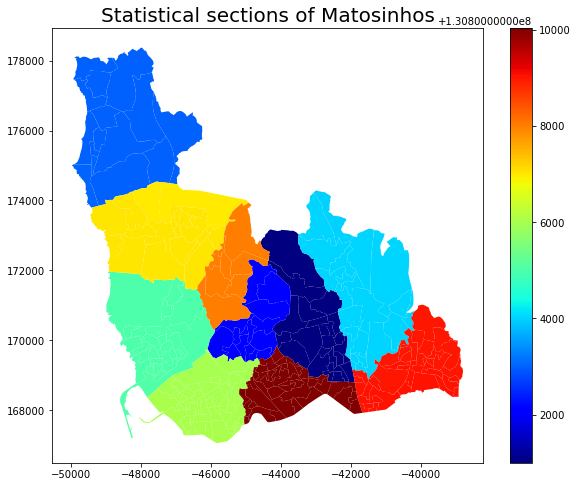

In [22]:
final_data = gpd.read_file('final_data')
final_data = final_data.plot(cmap = 'jet', column='SEC_EST', figsize = (10,8),legend=True)
plt.title("Statistical sections of Matosinhos",fontsize =20)

Text(0.5, 1.0, 'Number of people starting a short trip in Matosinhos')

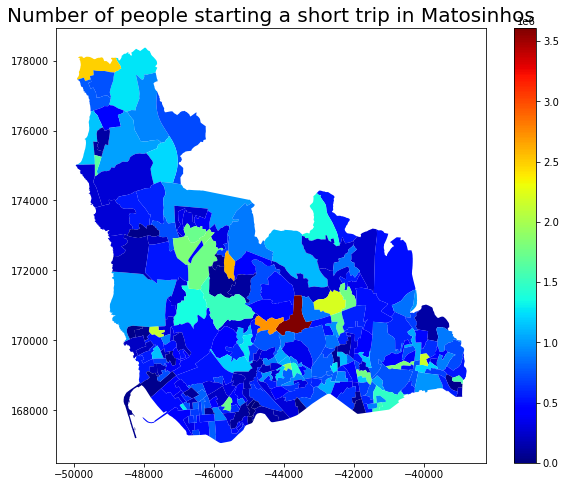

In [23]:
final_data = gpd.read_file('final_data')
final_data = final_data.plot(cmap = 'jet', column='start_peop', figsize = (10,8),legend=True)
plt.title("Number of people starting a short trip in Matosinhos",fontsize =20)

Text(0.5, 1.0, 'Number of people ending a short trip in Matosinhos')

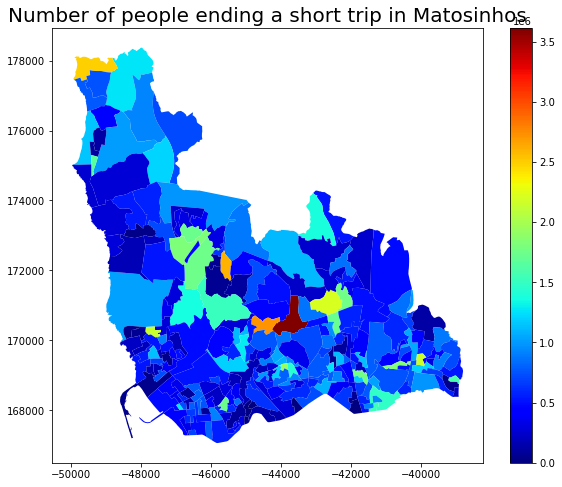

In [24]:
final_data = gpd.read_file('final_data')
final_data = final_data.plot(cmap = 'jet', column='end_people', figsize = (10,8),legend=True)
plt.title("Number of people ending a short trip in Matosinhos",fontsize =20)

Text(0.5, 1.0, 'Population distribution in Matoshinos')

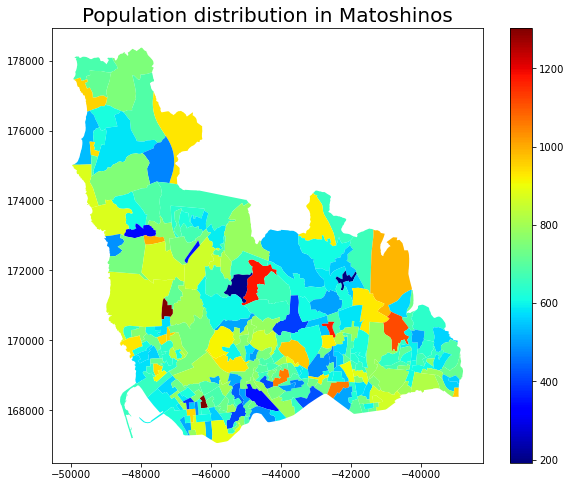

In [25]:
final_data = gpd.read_file('final_data')
final_data = final_data.plot(cmap = 'jet', column='total_pop', figsize = (10,8),legend=True)
plt.title("Population distribution in Matoshinos",fontsize =20)

Text(0.5, 1.0, 'Distribution of employed population in Matosinhos')

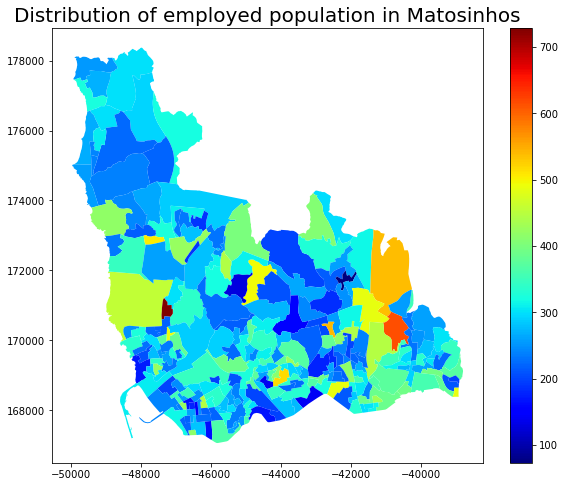

In [26]:
final_data = gpd.read_file('final_data')
final_data = final_data.plot(cmap = 'jet', column='employed_p', figsize = (10,8),legend=True)
plt.title("Distribution of employed population in Matosinhos",fontsize =20)

Text(0.5, 1.0, 'Distribution of young population in Matosinhos')

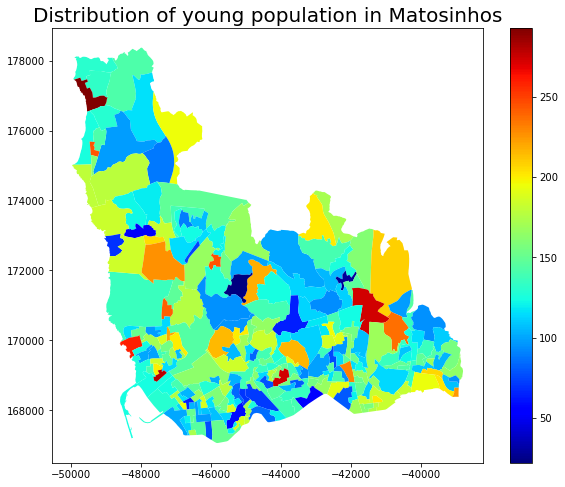

In [27]:
final_data = gpd.read_file('final_data')
final_data = final_data.plot(cmap = 'jet', column='young_popu', figsize = (10,8),legend=True)
plt.title("Distribution of young population in Matosinhos",fontsize =20)

Text(0.5, 1.0, 'Distribution of businesses in Matosinhos')

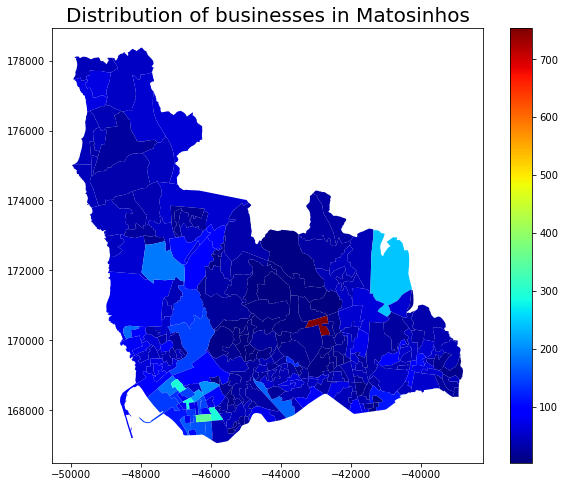

In [28]:
final_data = gpd.read_file('final_data')
final_data = final_data.plot(cmap = 'jet', column='number_bus', figsize = (10,8),legend=True)
plt.title("Distribution of businesses in Matosinhos",fontsize =20)

Text(0.5, 1.0, 'Distribution of schools in Matosinhos')

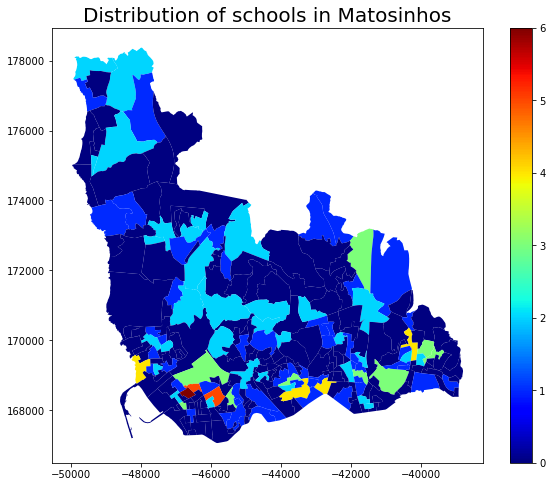

In [29]:
final_data = gpd.read_file('final_data')
final_data = final_data.plot(cmap = 'jet', column='number_sch', figsize = (10,8),legend=True)
plt.title("Distribution of schools in Matosinhos",fontsize =20)

Text(0.5, 1.0, 'Distribution of bus stops in Matosinhos')

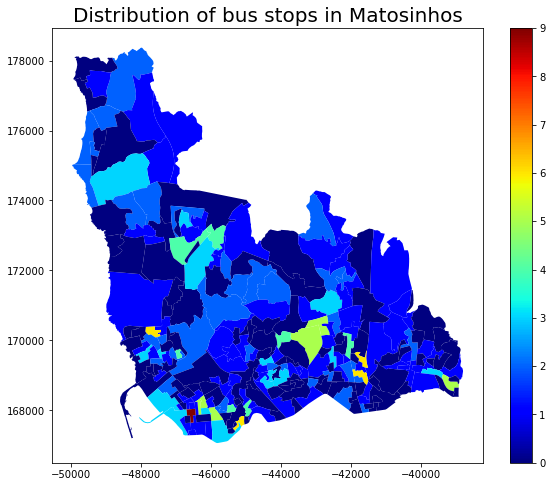

In [30]:
final_data = gpd.read_file('final_data')
final_data = final_data.plot(cmap = 'jet', column='bus_stop', figsize = (10,8),legend=True)
plt.title("Distribution of bus stops in Matosinhos",fontsize =20)

Text(0.5, 1.0, 'Distribution of metro stations in Matosinhos')

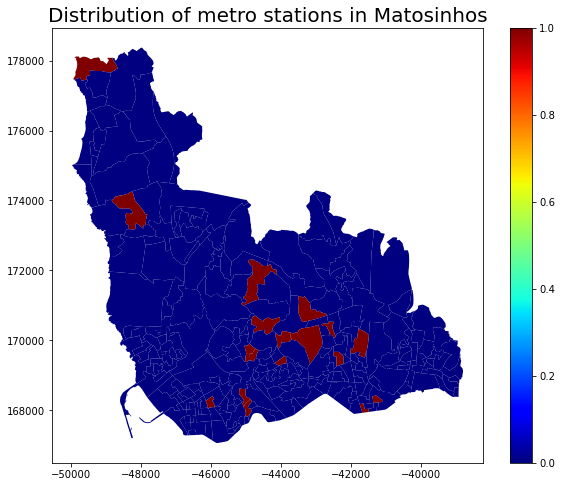

In [31]:
final_data = gpd.read_file('final_data')
final_data = final_data.plot(cmap = 'jet', column='metro_stat', figsize = (10,8),legend=True)
plt.title("Distribution of metro stations in Matosinhos",fontsize =20)

<AxesSubplot:>

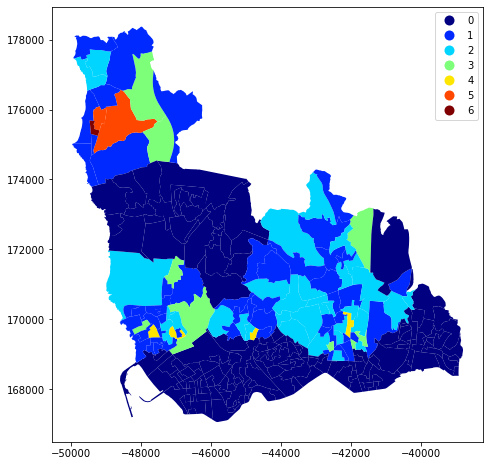

In [32]:
final_table.plot(cmap = 'jet', column='number_schools', figsize = (10,8),legend=True)


# 4. WHAT WOULD BE THE IMPACT OF INCREASING MICROMOBILITY TRIPS BY 10%? METRICS CALCULATION <a name="Impact"></a>

In [33]:
%load_ext google.cloud.bigquery
from google.cloud import bigquery
bqclient=bigquery.Client()
query= '''SELECT * FROM eurekathon-hub.CEIIA.shared_micromobility'''
df_micro_mob= (
    bqclient.query(query)
    .result()
    .to_dataframe()
)
df_micro_mob.head(10)

The google.cloud.bigquery extension is already loaded. To reload it, use:
  %reload_ext google.cloud.bigquery


vehicle_id                            session_id       type     start_time  \
0         256  70c1da29-f770-48e7-bb2e-e730530df253  E-SCOOTER  1559416935000   
1         256  50c8da23-1aa9-4709-b00a-7f92edb582af  E-SCOOTER  1559234619000   
2         256  d431ff2a-5b10-4e5f-830a-897f6d7c092c  E-SCOOTER  1559263312000   
3         256  b8d9eb23-b839-4345-a095-80bbc8348a87  E-SCOOTER  1563065085000   
4         256  14eeda55-c31a-4f33-83a6-0de7f045e9ee  E-SCOOTER  1562771829000   
5         256  f975f20f-e185-47b7-b106-a0a573cda785  E-SCOOTER  1562465458000   
6         256  c3c1b16c-25d0-42f7-b7fe-252812b7f9f3  E-SCOOTER  1562436942000   
7         256  c35b3152-b72b-4aa9-ba86-546ed2ae9d36  E-SCOOTER  1559506876000   
8         256  c68ada1b-0e89-4595-80af-c82bdf9a28f1  E-SCOOTER  1562691460000   
9         256  df1186f5-9a6b-469e-a83e-d0c6deacb156  E-SCOOTER  1560102906000   

        end_time        distance saved_emissions  \
0  1559417360000  1184.000000000   108.620160000   
1  1559236460000  1064.000000000    97.611360000   
2  1559265548000  4120.000000000   377.968800000   
3  1563065221000   368.000000000    33.760320000   
4  1562772707000  3152.000000000   289.164480000   
5  1562466826000  3413.000000000   313.791220000   
6  1562437520000  1205.000000000   110.787700000   
7  1559508151000  3931.000000000   360.629940000   
8  1562692830000  5315.000000000   487.598100000   
9  1560103421000   450.000000000    41.440500000   

                                               route  
0  0104000000230000000101000000000000C0FC6021C000...  
1  010400000022000000010100000000000080E95D21C000...  
2  01040000007D000000010100000000000060EB5B21C000...  
3  010400000035000000010100000000000040CE4F21C000...  
4  010400000069000000010100000000000080335021C000...  
5  0104000000620000000101000000000000C0D13F21C000...  
6  010400000026000000010100000000000060EB3F21C000...  
7  010400000071000000010100000000000020F76021C000...  
8  0104000000A2000000010100000000000080335321C000...  
9  0104000000AF000000010100000000000000767021C000...

### Emissions saved

In [34]:

df_micro_mob.type.value_counts() / len(df_micro_mob)*100

df_micro_mob['distance'] = df_micro_mob.distance.astype(float)
df_micro_mob['saved_emissions'] = df_micro_mob.saved_emissions.astype(float)

#TOTAL MOVEMENTS IN MICROMOBILITY : 158.444 SESSIONS
total_trips_micro = df_micro_mob['session_id'].count()
print ('\033[4m','Total micromobility trips: '+ str(total_trips_micro))


df_micro_mob = df_micro_mob.drop(df_micro_mob[df_micro_mob['distance'] < 3260.0].index)

#TOTAL KM MICROMOBILITY
total_km_micro = round(df_micro_mob['distance'].sum(),2)
## 231.650 KM
print ('Total micromobility distance: '+ str(total_km_micro))


#TOTAL SAVED EMMISION
total_saved_emissions_micro = round(df_micro_mob['saved_emissions'].sum(),2)
# metric 21.204.045,50273 (gigagramos)
print ('Total micromobility saved emissions: '+ str(total_saved_emissions_micro))

print ('Total saved CO2 emissions per km with micromobility: ' + str(round (total_saved_emissions_micro/total_km_micro*1000,2)) + ' grams per km')

E-SCOOTER    92.127818
SCOOTER       6.799879
BIKE          1.072303
Name: type, dtype: float64

 Total micromobility trips: 158444
Total micromobility distance: 231649938.46
Total micromobility saved emissions: 21204045.5
Total saved CO2 emissions per km with micromobility: 91.53 grams per km


### Extracting key figures about all trips and their proportion of short trips

In [35]:
long_trips= pd.read_csv('long_trips.csv') 
# long_trips.head()

#TOTAL KM INCLUDING LONG TRIPS ( 4 months 2019:february,march + july + august)
km_all_trips = round(long_trips['driving_distance'].sum(),2)
## 17.233.289 KM

#TOTAL TRIPS INCLUDING SHORT TRIPS
total_all_trips = len(long_trips)
#11.704.831

print ('\033[4m','Our dataset contains ' + str(total_all_trips) + ' trips that represent ' + str(km_all_trips) + ' kms' )

short_trips= pd.read_csv('short_trips.csv') 

#TOTAL KM SHORT TRIPS in 4 months 2019: february,march + july + august)
km_short_trips = round(short_trips['driving_distance'].sum(),2)

#TOTAL SHORT TRIPS
total_short_trips = len(short_trips)

#PERCENTEGES SHORT TRIPS OVER TOTAL BY TOTAL TRIPS
percentage = round(10572950/11704831*100,2)

#PERCENTEGES SHORT TRIPS OVER TOTAL BY KILOMETERS
km = round(11617361.970000017/17233289.580000013*100,2)

# EMISSIONS SHORT TRIPS
CO2_emission_short_trips = 11617361*91.53

print ('There are ' + str(total_short_trips) + ' short trips that represent ' + str(km_short_trips) + ' kms' )


print ('Short trips represent ' + str(percentage) + ' % of all trips')
print ('Short trips represent ' + str(km) + ' % of total kms')
print('Total CO2 emissions generated by short trips during 4 months in 2019: '+ str(CO2_emission_short_trips))


 Our dataset contains 11704831 trips that represent 17233289.58 kms
There are 10572950 short trips that represent 11617361.97 kms
Short trips represent 90.33 % of all trips
Short trips represent 67.41 % of total kms
Total CO2 emissions generated by short trips during 4 months in 2019: 1063337052.33


# 5. MODELING CLUSTER TO UNDERSTAND SIMILARITIES BETWEEN AREAS IN THE CITY <a name="Modeling"></a>

## Importing relevant libraries

In [36]:
cluster_df = pd.read_csv('final_table.csv')
cluster_df.columns
cluster_df = cluster_df.drop(['Unnamed: 0','SEC_EST_x','SEC_EST_y'],axis =1)
cluster_df.head(2)

Index(['Unnamed: 0', 'index', 'Bus_stops', 'SEC_EST', 'SEC_EST_x', 'SEC_EST_y',
       'employed_pop', 'end_people', 'end_trips', 'geometry', 'metro_stops',
       'number_businesses', 'number_schools', 'start_people', 'start_trips',
       'total_pop', 'young_population'],
      dtype='object')

index  Bus_stops    SEC_EST  employed_pop  end_people  end_trips  \
0    105          0  130801004           150     3613327     196007   
1      8          0  130802005           309     2719033     158171   

                                            geometry  metro_stops  \
0  POLYGON ((-45469.15689999983 168995.0933999996...            0   
1  POLYGON ((-42863.827700000256 170230.677899999...            1   

   number_businesses  number_schools  start_people  start_trips  total_pop  \
0                  9               0       3609128       195452        398   
1                  9               2       2717293       157956        783   

   young_population  
0                64  
1               165

## Running unsupervised learning on our DataFrame

In [37]:
# extracting numerical datatypes from df
numericals = cluster_df.select_dtypes(include=np.number)
numericals.head(2)

index  Bus_stops    SEC_EST  employed_pop  end_people  end_trips  \
0    105          0  130801004           150     3613327     196007   
1      8          0  130802005           309     2719033     158171   

   metro_stops  number_businesses  number_schools  start_people  start_trips  \
0            0                  9               0       3609128       195452   
1            1                  9               2       2717293       157956   

   total_pop  young_population  
0        398                64  
1        783               165

## choosing k -- inertia and silhouette method

KMeans(n_clusters=2, random_state=1234)

KMeans(n_clusters=3, random_state=1234)

KMeans(n_clusters=4, random_state=1234)

KMeans(n_clusters=5, random_state=1234)

KMeans(n_clusters=6, random_state=1234)

KMeans(n_clusters=7, random_state=1234)

KMeans(random_state=1234)

KMeans(n_clusters=9, random_state=1234)

KMeans(n_clusters=10, random_state=1234)

KMeans(n_clusters=11, random_state=1234)

KMeans(n_clusters=12, random_state=1234)

KMeans(n_clusters=13, random_state=1234)

KMeans(n_clusters=14, random_state=1234)

KMeans(n_clusters=15, random_state=1234)

KMeans(n_clusters=16, random_state=1234)

KMeans(n_clusters=17, random_state=1234)

KMeans(n_clusters=18, random_state=1234)

KMeans(n_clusters=19, random_state=1234)

<Figure size 1152x576 with 0 Axes>

Text(0.5, 0, 'k')

Text(0, 0.5, 'inertia')

([<matplotlib.axis.XTick at 0x7f38b5221250>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

Text(0.5, 1.0, 'Elbow Method showing the optimal k')

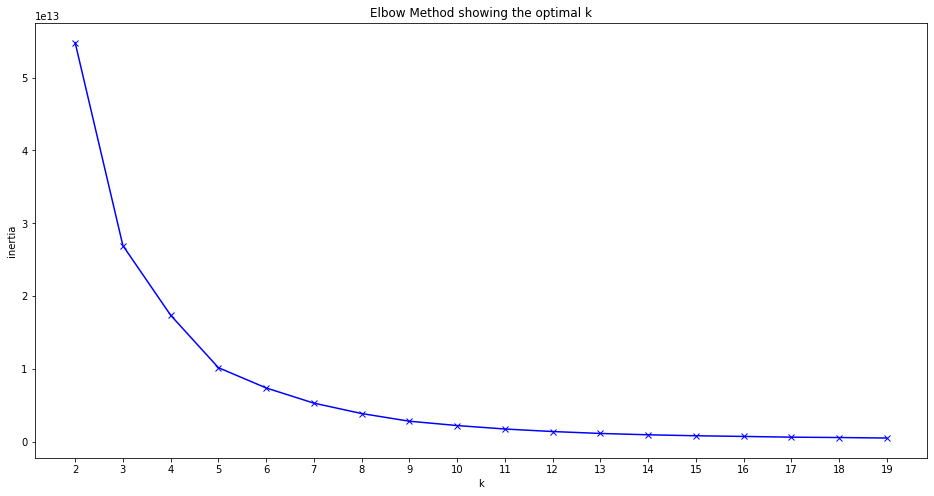

In [38]:
# CHOOSING K: Inertia and Silhouette score

# Inertia score method (elbow)

K = range(2, 20)  # nº of clusters from 2 to 20
inertia = []

for k in K:
    kmeans = KMeans(n_clusters=k,
                    random_state=1234)
    kmeans.fit(numericals)
    inertia.append(kmeans.inertia_) # inputing the inertia score

import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(16,8))
plt.plot(K, inertia, 'bx-')
plt.xlabel('k')
plt.ylabel('inertia')
plt.xticks(np.arange(min(K), max(K)+1, 1.0))
plt.title('Elbow Method showing the optimal k')

k 0 4 or 5 looks decent from the above plot

KMeans(n_clusters=2, random_state=1234)

KMeans(n_clusters=3, random_state=1234)

KMeans(n_clusters=4, random_state=1234)

KMeans(n_clusters=5, random_state=1234)

KMeans(n_clusters=6, random_state=1234)

KMeans(n_clusters=7, random_state=1234)

KMeans(random_state=1234)

KMeans(n_clusters=9, random_state=1234)

KMeans(n_clusters=10, random_state=1234)

KMeans(n_clusters=11, random_state=1234)

KMeans(n_clusters=12, random_state=1234)

KMeans(n_clusters=13, random_state=1234)

KMeans(n_clusters=14, random_state=1234)

KMeans(n_clusters=15, random_state=1234)

KMeans(n_clusters=16, random_state=1234)

KMeans(n_clusters=17, random_state=1234)

KMeans(n_clusters=18, random_state=1234)

KMeans(n_clusters=19, random_state=1234)

<Figure size 1152x576 with 0 Axes>

Text(0.5, 0, 'k')

Text(0, 0.5, 'silhouette score')

([<matplotlib.axis.XTick at 0x7f38b5240090>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

Text(0.5, 1.0, 'Optimal k')

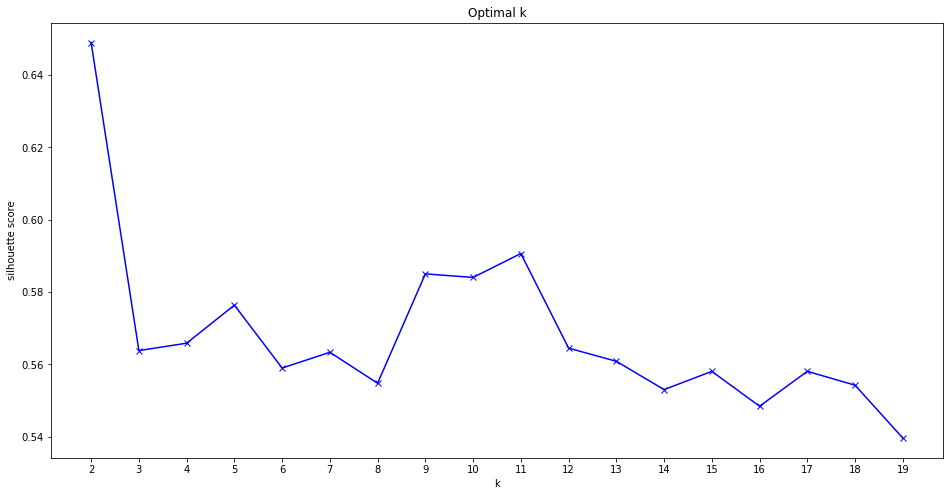

In [39]:
# Silhouette score method: the higher, the better
K = range(2, 20)
silhouette = []

for k in K:
    kmeans = KMeans(n_clusters=k,
                    random_state=1234)
    kmeans.fit(numericals)
    silhouette.append(silhouette_score(numericals, kmeans.predict(numericals)))

plt.figure(figsize=(16,8))
plt.plot(K, silhouette, 'bx-')
plt.xlabel('k')
plt.ylabel('silhouette score')
plt.xticks(np.arange(min(K), max(K)+1, 1.0))
plt.title('Optimal k')

k=5 looks like it would be best option!

In [40]:
# CLUSTERING: K-Means
scaler = StandardScaler()
# Normalizing 
numerical_norm = scaler.fit_transform(numericals)
numerical_norm

# KMeans: grouping the data set
kmeans = cluster.KMeans(n_clusters=5, random_state=1234)

# Fiting kmeans into my numerical dataset (numerical_norm)
kmeans.fit(numerical_norm)

# Creating the kmeans cluster prediction for our dataset
clusters = kmeans.predict(numerical_norm)

array([[-0.29322347, -0.86640569, -1.75006576, ...,  5.26877631,
        -1.83767657, -1.75989089],
       [-1.61613867, -0.86640569, -1.40161987, ...,  3.98448261,
         0.57818652,  0.53656083],
       [-0.79784061,  0.50047037,  0.68627069, ...,  3.18402539,
         0.74761068,  0.26371508],
       ...,
       [ 1.69796848,  1.86734644,  1.3936054 , ..., -1.42574506,
         0.10756384,  0.67298371],
       [ 1.71160678, -0.18296766,  1.3939535 , ..., -1.42574506,
         0.20168838, -0.35018785],
       [ 1.72524508, -0.86640569,  1.39499779, ..., -1.42574506,
        -0.09951014,  0.90035516]])

KMeans(n_clusters=5, random_state=1234)

In [41]:
# Checking the size of the clusters
pd.Series(clusters).value_counts().sort_index()

0    75
1    36
2    35
3    51
4    57
dtype: int64

In [42]:
kmeans = KMeans(n_clusters=5,
                init="random",
                n_init=1000,  
                max_iter=10000,
                tol=0,
                random_state=12345)
kmeans.fit(numerical_norm)
# Metric to check the performance of our Unsupervised learning algorithm
print(kmeans.inertia_)

KMeans(init='random', max_iter=10000, n_clusters=5, n_init=1000,
       random_state=12345, tol=0)

1884.1023043942498


## Assigning Clusters

In [43]:
clusters = pd.DataFrame(clusters)

## Concatenating this with original dataframe

In [44]:
ms_clusters_df = pd.concat([cluster_df,clusters],axis=1)
ms_clusters_df.head()

index  Bus_stops    SEC_EST  employed_pop  end_people  end_trips  \
0    105          0  130801004           150     3613327     196007   
1      8          0  130802005           309     2719033     158171   
2     68          2  130808003           442     2607595     135391   
3     13          0  130803002           253     2490593     138001   
4    104          3  130801003           185     2214936     138049   

                                            geometry  metro_stops  \
0  POLYGON ((-45469.15689999983 168995.0933999996...            0   
1  POLYGON ((-42863.827700000256 170230.677899999...            1   
2  POLYGON ((-41137.57670000009 170501.8991999998...            0   
3  POLYGON ((-43651.523000000045 170009.980100000...            1   
4  POLYGON ((-45861.84580000024 169482.9232999999...            0   

   number_businesses  number_schools  start_people  start_trips  total_pop  \
0                  9               0       3609128       195452        398   
1                  9               2       2717293       157956        783   
2                 40               1       2601444       134586        810   
3                 44               2       2485871       137341        682   
4                  4               0       2207231       136966        506   

   young_population  0  
0                64  1  
1               165  1  
2               153  1  
3               131  1  
4                93  1

In [45]:
ms_clusters_df = ms_clusters_df.rename(columns={0:'clusters'})
ms_clusters_df.columns
ms_clusters_df.head()
ms_clusters_df['SEC_EST'].dtype

Index(['index', 'Bus_stops', 'SEC_EST', 'employed_pop', 'end_people',
       'end_trips', 'geometry', 'metro_stops', 'number_businesses',
       'number_schools', 'start_people', 'start_trips', 'total_pop',
       'young_population', 'clusters'],
      dtype='object')

index  Bus_stops    SEC_EST  employed_pop  end_people  end_trips  \
0    105          0  130801004           150     3613327     196007   
1      8          0  130802005           309     2719033     158171   
2     68          2  130808003           442     2607595     135391   
3     13          0  130803002           253     2490593     138001   
4    104          3  130801003           185     2214936     138049   

                                            geometry  metro_stops  \
0  POLYGON ((-45469.15689999983 168995.0933999996...            0   
1  POLYGON ((-42863.827700000256 170230.677899999...            1   
2  POLYGON ((-41137.57670000009 170501.8991999998...            0   
3  POLYGON ((-43651.523000000045 170009.980100000...            1   
4  POLYGON ((-45861.84580000024 169482.9232999999...            0   

   number_businesses  number_schools  start_people  start_trips  total_pop  \
0                  9               0       3609128       195452        398   
1                  9               2       2717293       157956        783   
2                 40               1       2601444       134586        810   
3                 44               2       2485871       137341        682   
4                  4               0       2207231       136966        506   

   young_population  clusters  
0                64         1  
1               165         1  
2               153         1  
3               131         1  
4                93         1

dtype('int64')

## Analyzing each cluster in detail

In [46]:
#Filtering clusters
cluster0 = ms_clusters_df.drop(ms_clusters_df[ms_clusters_df['clusters'] > 0].index)
cluster0.head()

index  Bus_stops    SEC_EST  employed_pop  end_people  end_trips  \
54    118          0  130801024           228      929542      59709   
57    180          5  130806025           221      907185      58756   
66    143          1  130804013           257      858895      49893   
67    138          1  130804006           259      852482      51362   
71    181          3  130806026           163      801488      50771   

                                             geometry  metro_stops  \
54  POLYGON ((-46281.09549999982 168532.2806000001...            0   
57  POLYGON ((-40466.5251000002 170032.47199999914...            0   
66  POLYGON ((-46734.865600000136 167706.802799999...            0   
67  POLYGON ((-46624.11060000025 168222.3882999997...            0   
71  POLYGON ((-39689.33519999962 169631.6272, -396...            0   

    number_businesses  number_schools  start_people  start_trips  total_pop  \
54                 42               0        930474        59841        601   
57                292               0        906617        58673        556   
66                 59               0        859203        49941        568   
67                 47               0        852776        51390        549   
71                159               0        802042        50850        533   

    young_population  clusters  
54               141         0  
57               107         0  
66                98         0  
67               126         0  
71                77         0

In [47]:
cluster0.describe()

index  Bus_stops       SEC_EST  employed_pop     end_people  \
count   75.000000   75.00000  7.500000e+01     75.000000      75.000000   
mean   139.320000    1.92000  1.308050e+08    227.720000  434060.360000   
std     46.811629    1.73797  2.610886e+03     45.897229  248495.882068   
min      1.000000    0.00000  1.308010e+08     73.000000   37114.000000   
25%    112.000000    1.00000  1.308030e+08    207.500000  247730.500000   
50%    139.000000    1.00000  1.308050e+08    228.000000  450737.000000   
75%    176.500000    3.00000  1.308060e+08    255.500000  634031.000000   
max    242.000000    9.00000  1.308100e+08    329.000000  929542.000000   

          end_trips  metro_stops  number_businesses  number_schools  \
count     75.000000    75.000000          75.000000       75.000000   
mean   28116.106667     0.053333          75.333333        0.186667   
std    15580.088871     0.226210         103.868463        0.392268   
min     2653.000000     0.000000           5.000000        0.000000   
25%    17398.000000     0.000000          25.500000        0.000000   
50%    29558.000000     0.000000          45.000000        0.000000   
75%    39245.000000     0.000000          79.500000        0.000000   
max    59709.000000     1.000000         754.000000        1.000000   

        start_people   start_trips   total_pop  young_population  clusters  
count      75.000000     75.000000   75.000000         75.000000      75.0  
mean   434215.493333  28137.506667  572.506667        108.906667       0.0  
std    248550.588487  15587.705070  125.032036         30.995280       0.0  
min     37100.000000   2651.000000  192.000000         22.000000       0.0  
25%    247478.500000  17413.500000  513.000000         95.500000       0.0  
50%    451139.000000  29589.000000  583.000000        111.000000       0.0  
75%    633507.000000  39267.500000  624.000000        124.000000       0.0  
max    930474.000000  59841.000000  949.000000        188.000000       0.0

In [48]:
cluster1 = ms_clusters_df.drop(ms_clusters_df[ms_clusters_df['clusters'] > 1].index)
cluster1= cluster1.drop(cluster1[cluster1['clusters'] < 1].index)
cluster1.head()

index  Bus_stops    SEC_EST  employed_pop  end_people  end_trips  \
0    105          0  130801004           150     3613327     196007   
1      8          0  130802005           309     2719033     158171   
2     68          2  130808003           442     2607595     135391   
3     13          0  130803002           253     2490593     138001   
4    104          3  130801003           185     2214936     138049   

                                            geometry  metro_stops  \
0  POLYGON ((-45469.15689999983 168995.0933999996...            0   
1  POLYGON ((-42863.827700000256 170230.677899999...            1   
2  POLYGON ((-41137.57670000009 170501.8991999998...            0   
3  POLYGON ((-43651.523000000045 170009.980100000...            1   
4  POLYGON ((-45861.84580000024 169482.9232999999...            0   

   number_businesses  number_schools  start_people  start_trips  total_pop  \
0                  9               0       3609128       195452        398   
1                  9               2       2717293       157956        783   
2                 40               1       2601444       134586        810   
3                 44               2       2485871       137341        682   
4                  4               0       2207231       136966        506   

   young_population  clusters  
0                64         1  
1               165         1  
2               153         1  
3               131         1  
4                93         1

In [49]:
cluster2 = ms_clusters_df.drop(ms_clusters_df[ms_clusters_df['clusters'] > 2].index)
cluster3 = ms_clusters_df.drop(ms_clusters_df[ms_clusters_df['clusters'] > 3].index)
cluster4 = ms_clusters_df.drop(ms_clusters_df[ms_clusters_df['clusters'] > 4].index)

In [50]:
cluster2= cluster2.drop(cluster2[cluster2['clusters'] < 2].index)
cluster3= cluster3.drop(cluster3[cluster3['clusters'] < 3].index)
cluster4= cluster4.drop(cluster4[cluster4['clusters'] < 4].index)

In [51]:
cluster2['clusters'].value_counts()

2    35
Name: clusters, dtype: int64

## Running descriptive statistics on each cluster

In [52]:
cluster0.describe()
cluster1.describe()
cluster2.describe()
cluster3.describe()
cluster4.describe()

index  Bus_stops       SEC_EST  employed_pop     end_people  \
count   75.000000   75.00000  7.500000e+01     75.000000      75.000000   
mean   139.320000    1.92000  1.308050e+08    227.720000  434060.360000   
std     46.811629    1.73797  2.610886e+03     45.897229  248495.882068   
min      1.000000    0.00000  1.308010e+08     73.000000   37114.000000   
25%    112.000000    1.00000  1.308030e+08    207.500000  247730.500000   
50%    139.000000    1.00000  1.308050e+08    228.000000  450737.000000   
75%    176.500000    3.00000  1.308060e+08    255.500000  634031.000000   
max    242.000000    9.00000  1.308100e+08    329.000000  929542.000000   

          end_trips  metro_stops  number_businesses  number_schools  \
count     75.000000    75.000000          75.000000       75.000000   
mean   28116.106667     0.053333          75.333333        0.186667   
std    15580.088871     0.226210         103.868463        0.392268   
min     2653.000000     0.000000           5.000000        0.000000   
25%    17398.000000     0.000000          25.500000        0.000000   
50%    29558.000000     0.000000          45.000000        0.000000   
75%    39245.000000     0.000000          79.500000        0.000000   
max    59709.000000     1.000000         754.000000        1.000000   

        start_people   start_trips   total_pop  young_population  clusters  
count      75.000000     75.000000   75.000000         75.000000      75.0  
mean   434215.493333  28137.506667  572.506667        108.906667       0.0  
std    248550.588487  15587.705070  125.032036         30.995280       0.0  
min     37100.000000   2651.000000  192.000000         22.000000       0.0  
25%    247478.500000  17413.500000  513.000000         95.500000       0.0  
50%    451139.000000  29589.000000  583.000000        111.000000       0.0  
75%    633507.000000  39267.500000  624.000000        124.000000       0.0  
max    930474.000000  59841.000000  949.000000        188.000000       0.0

index  Bus_stops       SEC_EST  employed_pop    end_people  \
count   36.000000  36.000000  3.600000e+01     36.000000  3.600000e+01   
mean    96.611111   1.638889  1.308054e+08    281.111111  1.672344e+06   
std     69.604712   1.692889  3.131427e+03     66.929719  5.455608e+05   
min      8.000000   0.000000  1.308010e+08    150.000000  1.104778e+06   
25%     35.000000   0.000000  1.308030e+08    232.500000  1.256528e+06   
50%     80.500000   1.000000  1.308050e+08    277.500000  1.556810e+06   
75%    131.500000   2.000000  1.308090e+08    312.250000  1.816968e+06   
max    236.000000   6.000000  1.308100e+08    442.000000  3.613327e+06   

           end_trips  metro_stops  number_businesses  number_schools  \
count      36.000000    36.000000          36.000000       36.000000   
mean    95774.111111     0.083333          43.722222        0.888889   
std     28536.050091     0.280306          33.412240        0.918937   
min     65446.000000     0.000000           4.000000        0.000000   
25%     76802.250000     0.000000          20.250000        0.000000   
50%     86723.500000     0.000000          40.000000        1.000000   
75%    103974.750000     0.000000          47.500000        2.000000   
max    196007.000000     1.000000         131.000000        3.000000   

       start_people    start_trips   total_pop  young_population  clusters  
count  3.600000e+01      36.000000   36.000000         36.000000      36.0  
mean   1.671981e+06   95724.305556  675.583333        133.750000       1.0  
std    5.439413e+05   28331.604157  119.896950         31.888534       0.0  
min    1.106403e+06   65389.000000  398.000000         64.000000       1.0  
25%    1.256613e+06   76791.000000  594.500000        110.500000       1.0  
50%    1.558088e+06   87124.500000  680.500000        139.500000       1.0  
75%    1.814630e+06  103564.000000  751.000000        155.500000       1.0  
max    3.609128e+06  195452.000000  922.000000        201.000000       1.0

index  Bus_stops       SEC_EST  employed_pop    end_people  \
count   35.000000  35.000000  3.500000e+01     35.000000  3.500000e+01   
mean    96.228571   0.914286  1.308044e+08    418.828571  6.090624e+05   
std     64.083166   1.197336  2.545705e+03    100.088339  2.963571e+05   
min      2.000000   0.000000  1.308010e+08    241.000000  1.017340e+05   
25%     28.500000   0.000000  1.308020e+08    356.000000  3.539440e+05   
50%    119.000000   1.000000  1.308040e+08    413.000000  5.835670e+05   
75%    148.000000   1.000000  1.308050e+08    487.000000  7.903160e+05   
max    227.000000   5.000000  1.308100e+08    729.000000  1.189229e+06   

          end_trips  metro_stops  number_businesses  number_schools  \
count     35.000000    35.000000          35.000000       35.000000   
mean   38464.885714     0.057143          47.085714        0.628571   
std    17105.675325     0.235504          44.966897        0.770245   
min     7716.000000     0.000000           7.000000        0.000000   
25%    22033.500000     0.000000          19.500000        0.000000   
50%    41450.000000     0.000000          37.000000        0.000000   
75%    49520.000000     0.000000          58.500000        1.000000   
max    71552.000000     1.000000         243.000000        2.000000   

       start_people   start_trips    total_pop  young_population  clusters  
count  3.500000e+01     35.000000    35.000000         35.000000      35.0  
mean   6.093567e+05  38506.142857   942.771429        207.114286       2.0  
std    2.963255e+05  17112.995850   135.318814         38.588913       0.0  
min    1.016670e+05   7706.000000   734.000000        136.000000       2.0  
25%    3.549485e+05  22174.000000   865.500000        186.000000       2.0  
50%    5.839630e+05  41734.000000   930.000000        200.000000       2.0  
75%    7.900535e+05  49638.500000   964.500000        228.000000       2.0  
max    1.187929e+06  71554.000000  1303.000000        293.000000       2.0

index  Bus_stops       SEC_EST  employed_pop    end_people  \
count  51.000000  51.000000  5.100000e+01     51.000000  5.100000e+01   
mean   51.117647   0.705882  1.308064e+08    289.921569  5.788881e+05   
std    25.938116   0.878501  2.467511e+03     52.667198  2.556941e+05   
min     0.000000   0.000000  1.308010e+08    171.000000  8.546000e+04   
25%    31.500000   0.000000  1.308050e+08    252.500000  3.821770e+05   
50%    49.000000   1.000000  1.308060e+08    292.000000  5.361370e+05   
75%    72.500000   1.000000  1.308090e+08    324.000000  7.542025e+05   
max    96.000000   4.000000  1.308100e+08    423.000000  1.078239e+06   

          end_trips  metro_stops  number_businesses  number_schools  \
count     51.000000    51.000000          51.000000       51.000000   
mean   36220.392157     0.078431          56.352941        2.137255   
std    15745.319885     0.271524          49.115710        1.233201   
min     5905.000000     0.000000           9.000000        1.000000   
25%    23598.500000     0.000000          30.000000        1.000000   
50%    36312.000000     0.000000          48.000000        2.000000   
75%    45369.500000     0.000000          63.000000        3.000000   
max    65261.000000     1.000000         292.000000        6.000000   

       start_people   start_trips   total_pop  young_population  clusters  
count  5.100000e+01     51.000000   51.000000         51.000000      51.0  
mean   5.787319e+05  36198.549020  669.862745        137.019608       3.0  
std    2.556473e+05  15735.447547   69.440628         24.490398       0.0  
min    8.545200e+04   5904.000000  501.000000         92.000000       3.0  
25%    3.818055e+05  23568.500000  622.500000        116.000000       3.0  
50%    5.367910e+05  36369.000000  663.000000        136.000000       3.0  
75%    7.538980e+05  45213.000000  711.500000        155.500000       3.0  
max    1.078312e+06  65187.000000  814.000000        194.000000       3.0

index  Bus_stops       SEC_EST  employed_pop    end_people  \
count   57.000000  57.000000  5.700000e+01     57.000000  5.700000e+01   
mean   214.543860   0.894737  1.308086e+08    323.070175  4.904444e+05   
std     30.577811   1.096817  1.615526e+03     55.743629  3.195277e+05   
min     94.000000   0.000000  1.308050e+08    222.000000  0.000000e+00   
25%    202.000000   0.000000  1.308070e+08    288.000000  2.743660e+05   
50%    218.000000   1.000000  1.308090e+08    317.000000  4.841360e+05   
75%    238.000000   1.000000  1.308100e+08    364.000000  6.869310e+05   
max    253.000000   4.000000  1.308100e+08    486.000000  1.186214e+06   

          end_trips  metro_stops  number_businesses  number_schools  \
count     57.000000    57.000000          57.000000       57.000000   
mean   31980.052632     0.087719          50.964912        0.017544   
std    19795.248814     0.285401          44.143421        0.132453   
min        0.000000     0.000000          12.000000        0.000000   
25%    18853.000000     0.000000          26.000000        0.000000   
50%    34223.000000     0.000000          33.000000        0.000000   
75%    46030.000000     0.000000          58.000000        0.000000   
max    72086.000000     1.000000         211.000000        1.000000   

       start_people   start_trips    total_pop  young_population  clusters  
count  5.700000e+01     57.000000    57.000000         57.000000      57.0  
mean   4.904285e+05  31977.561404   720.333333        152.561404       4.0  
std    3.195545e+05  19795.320427   101.335252         33.673865       0.0  
min    0.000000e+00      0.000000   504.000000         70.000000       4.0  
25%    2.742270e+05  18773.000000   655.000000        130.000000       4.0  
50%    4.846520e+05  34296.000000   712.000000        152.000000       4.0  
75%    6.869800e+05  46248.000000   778.000000        173.000000       4.0  
max    1.184174e+06  71785.000000  1058.000000        245.000000       4.0

In [53]:
cluster0.to_csv('cluster0.csv')

In [54]:
cluster1.to_csv('cluster1.csv')

In [55]:
cluster2.to_csv('cluster2.csv')

In [56]:
cluster3.to_csv('cluster3.csv')

In [57]:
cluster4.to_csv('cluster4.csv')

### Map of final clusters

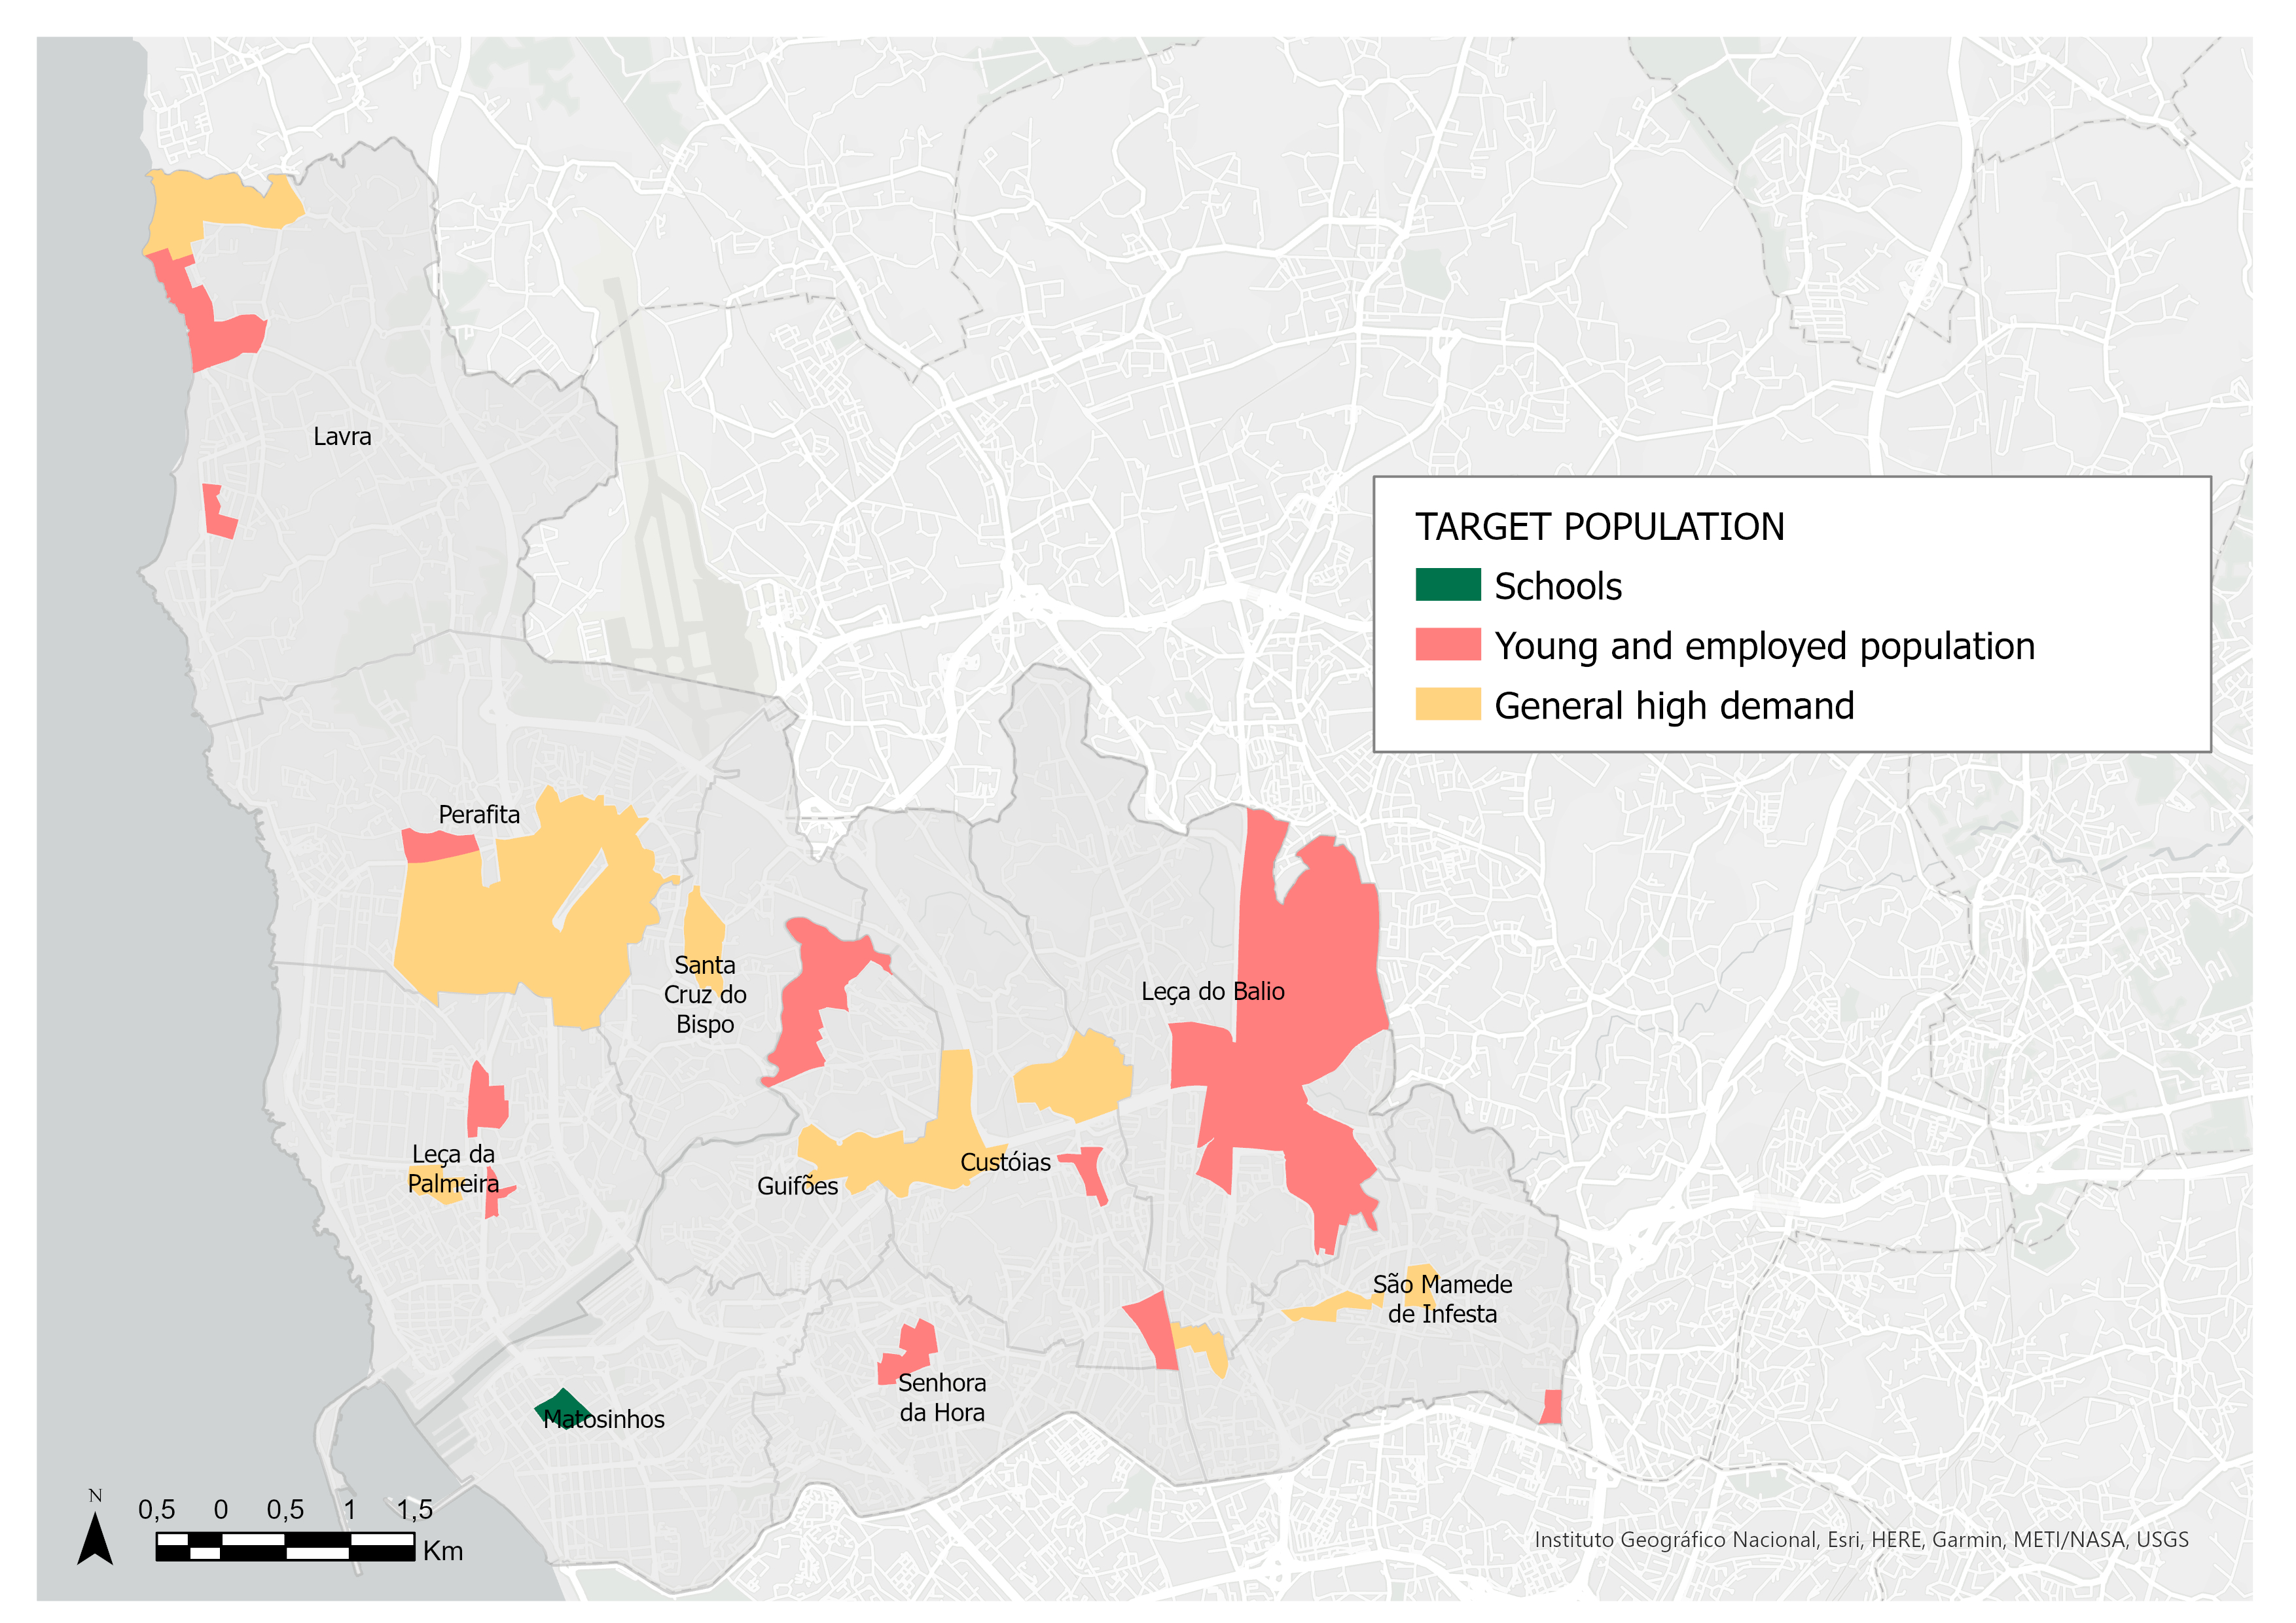

In [58]:
from IPython.display import Image
Image("areas_final.jpg")